In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Text processing
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
import re

# Image processing
from PIL import Image
import cv2

# Interactive visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style for matplotlib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ All libraries imported successfully!")
print(f"📊 Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ All libraries imported successfully!
📊 Analysis started at: 2025-07-14 19:30:08


In [19]:
# Configuration and paths
DATA_DIR = Path("../data")
RAW_DATA_DIR = DATA_DIR / "raw" / "telegram_messages"
IMAGES_DIR = DATA_DIR / "images"
LOGS_DIR = DATA_DIR / "logs"

# Find the most recent data directory
available_dates = [d for d in RAW_DATA_DIR.glob("*") if d.is_dir()]
if not available_dates:
    raise FileNotFoundError("No scraped data found! Please run the scraper first.")

latest_date = max(available_dates, key=lambda x: x.name)
print(f"📅 Using data from: {latest_date.name}")

# Data file paths
COMBINED_DATA_FILE = latest_date / "combined_medical_channels.json"
METADATA_FILE = latest_date / "scrape_metadata.json"

# Check if files exist
if not COMBINED_DATA_FILE.exists():
    raise FileNotFoundError(f"Combined data file not found: {COMBINED_DATA_FILE}")
if not METADATA_FILE.exists():
    raise FileNotFoundError(f"Metadata file not found: {METADATA_FILE}")

print(f"📁 Data directory: {latest_date}")
print(f"📊 Combined data file: {COMBINED_DATA_FILE.name}")
print(f"📋 Metadata file: {METADATA_FILE.name}")
print(f"🖼️  Images directory: {IMAGES_DIR}")
print("✅ Configuration completed!")


📅 Using data from: 2025-07-13
📁 Data directory: ..\data\raw\telegram_messages\2025-07-13
📊 Combined data file: combined_medical_channels.json
📋 Metadata file: scrape_metadata.json
🖼️  Images directory: ..\data\images
✅ Configuration completed!


In [20]:
# Load and examine the data
print("🔍 Loading scraped data...")

# Load combined data
with open(COMBINED_DATA_FILE, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

# Load metadata
with open(METADATA_FILE, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(raw_data)
print(f"📊 Loaded {len(df)} messages")

# Display metadata
print("\n📋 Scraping Metadata:")
print(f"  Scrape Date: {metadata.get('scrape_date', 'Unknown')}")
print(f"  Total Messages: {metadata.get('total_messages', 'Unknown'):,}")
print(f"  Channels Scraped: {len(metadata.get('channels_scraped', []))}")

print("\n📈 Channel Statistics:")
for channel, count in metadata.get('channel_counts', {}).items():
    print(f"  {channel}: {count:,} messages")

print("\n📊 DataFrame Info:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {list(df.columns)}")
print(f"  Memory Usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

# Display first few rows
print("\n📋 Sample Data:")
df.head()


🔍 Loading scraped data...
📊 Loaded 1285 messages

📋 Scraping Metadata:
  Scrape Date: 2025-07-13
  Total Messages: 1,285
  Channels Scraped: 2

📈 Channel Statistics:
  @lobelia4cosmetics: 491 messages
  @tikvahpharma: 794 messages

📊 DataFrame Info:
  Shape: (1285, 11)
  Columns: ['id', 'channel', 'date', 'text', 'views', 'forwards', 'replies', 'media_type', 'media_path', 'raw_data', 'media_size']
  Memory Usage: 4.31 MB

📋 Sample Data:


,id,channel,date,text,views,forwards,replies,media_type,media_path,raw_data,media_size
0,18545,@lobelia4cosmetics,2025-07-13T13:07:02+00:00,AQUAPHOR BABY **\nPrice 5000 birr \nTelegram *...,323.0,0.0,0,photo,images\lobelia4cosmetics\18545_20250713_184232...,"{'message_id': 18545, 'from_id': None, 'reply_...",82866.0
1,18544,@lobelia4cosmetics,2025-07-13T13:07:02+00:00,AVEENO BABY \nPrice 5000 birr \nTelegram :-@Lo...,280.0,0.0,0,photo,images\lobelia4cosmetics\18544_20250713_184235...,"{'message_id': 18544, 'from_id': None, 'reply_...",28531.0
2,18543,@lobelia4cosmetics,2025-07-13T13:07:02+00:00,ARGON OIL \nPrice 5000 birr \nTelegram https:/...,114.0,0.0,0,photo,images\lobelia4cosmetics\18543_20250713_184237...,"{'message_id': 18543, 'from_id': None, 'reply_...",17233.0
3,18542,@lobelia4cosmetics,2025-07-13T13:07:02+00:00,BIO OIL \nPrice 3000 birr \nTelegram https://t...,170.0,0.0,0,photo,images\lobelia4cosmetics\18542_20250713_184239...,"{'message_id': 18542, 'from_id': None, 'reply_...",21779.0
4,18541,@lobelia4cosmetics,2025-07-13T13:07:02+00:00,VITAMIN D3 1000IU 650 SOFT GELS \nPrice 6500 b...,67.0,0.0,0,photo,images\lobelia4cosmetics\18541_20250713_184241...,"{'message_id': 18541, 'from_id': None, 'reply_...",21590.0


In [21]:
# Data preprocessing and cleaning
print("🧹 Preprocessing data...")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Add derived columns
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Clean text data
df['text_length'] = df['text'].str.len()
df['has_media'] = df['media_type'].notna()
df['word_count'] = df['text'].str.split().str.len()

# Clean channel names for better display
df['channel_clean'] = df['channel'].str.replace('@', '', regex=False)

# Filter out empty messages
df_clean = df[df['text'].str.len() > 0].copy()

print(f"📊 Data after preprocessing:")
print(f"  Total messages: {len(df):,}")
print(f"  Messages with text: {len(df_clean):,}")
print(f"  Messages with media: {df['has_media'].sum():,}")
print(f"  Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")

# Display basic statistics
print("\n📈 Basic Statistics:")
print(df_clean[['text_length', 'word_count', 'views', 'forwards']].describe())


🧹 Preprocessing data...
📊 Data after preprocessing:
  Total messages: 1,285
  Messages with text: 1,224
  Messages with media: 731
  Date range: 2025-06-13 to 2025-07-13

📈 Basic Statistics:
       text_length   word_count         views     forwards
count  1224.000000  1224.000000   1198.000000  1198.000000
mean    807.095588   110.681373   2197.151085     3.505843
std     986.400840   126.893881   6782.736405    14.407585
min       9.000000     1.000000     67.000000     0.000000
25%     361.000000    58.000000    506.250000     0.000000
50%     398.000000    64.000000    657.000000     0.000000
75%     708.000000    89.000000    854.000000     2.000000
max    3989.000000   595.000000  56627.000000   153.000000


📊 Analyzing channel activity...
📈 Channel Statistics:
                   Messages  Avg_Text_Length  Median_Text_Length  \
channel_clean                                                      
tikvahpharma            750          1073.77               550.0   
lobelia4cosmetics       474           385.14               386.0   

                   Avg_Word_Count  Median_Word_Count  Avg_Views  Median_Views  \
channel_clean                                                                   
tikvahpharma               140.42               73.0    3211.28         699.5   
lobelia4cosmetics           63.63               64.0     648.15         600.0   

                   Max_Views  Avg_Forwards  Median_Forwards  Max_Forwards  \
channel_clean                                                               
tikvahpharma         56627.0          5.11              0.0         153.0   
lobelia4cosmetics     5276.0          1.06              1.0          13.0   

                   Media_Count  
channe

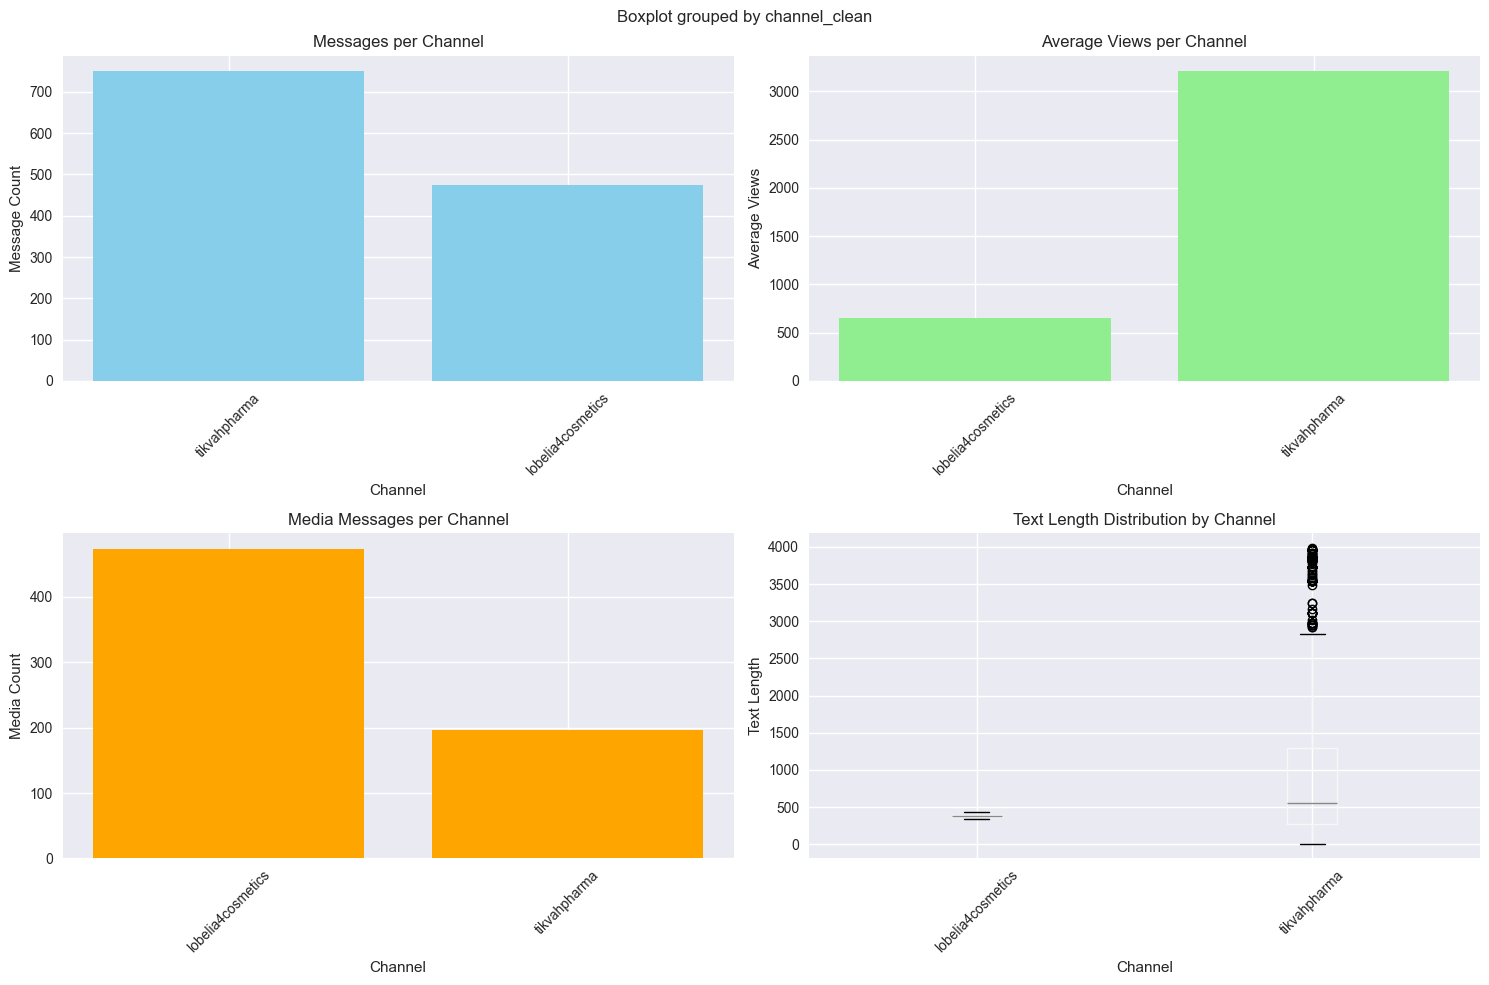

In [22]:
# Channel Analysis and Comparison
print("📊 Analyzing channel activity...")

# Channel statistics
channel_stats = df_clean.groupby('channel_clean').agg({
    'id': 'count',
    'text_length': ['mean', 'median'],
    'word_count': ['mean', 'median'],
    'views': ['mean', 'median', 'max'],
    'forwards': ['mean', 'median', 'max'],
    'has_media': 'sum'
}).round(2)

channel_stats.columns = ['Messages', 'Avg_Text_Length', 'Median_Text_Length', 
                        'Avg_Word_Count', 'Median_Word_Count', 'Avg_Views', 
                        'Median_Views', 'Max_Views', 'Avg_Forwards', 
                        'Median_Forwards', 'Max_Forwards', 'Media_Count']

print("📈 Channel Statistics:")
print(channel_stats.sort_values('Messages', ascending=False))

# Visualization: Channel message counts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Messages per channel
channel_counts = df_clean['channel_clean'].value_counts()
axes[0, 0].bar(channel_counts.index, channel_counts.values, color='skyblue')
axes[0, 0].set_title('Messages per Channel')
axes[0, 0].set_xlabel('Channel')
axes[0, 0].set_ylabel('Message Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Average views per channel
avg_views = df_clean.groupby('channel_clean')['views'].mean()
axes[0, 1].bar(avg_views.index, avg_views.values, color='lightgreen')
axes[0, 1].set_title('Average Views per Channel')
axes[0, 1].set_xlabel('Channel')
axes[0, 1].set_ylabel('Average Views')
axes[0, 1].tick_params(axis='x', rotation=45)

# Media distribution
media_counts = df_clean.groupby('channel_clean')['has_media'].sum()
axes[1, 0].bar(media_counts.index, media_counts.values, color='orange')
axes[1, 0].set_title('Media Messages per Channel')
axes[1, 0].set_xlabel('Channel')
axes[1, 0].set_ylabel('Media Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Text length distribution
df_clean.boxplot(column='text_length', by='channel_clean', ax=axes[1, 1])
axes[1, 1].set_title('Text Length Distribution by Channel')
axes[1, 1].set_xlabel('Channel')
axes[1, 1].set_ylabel('Text Length')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


⏰ Analyzing temporal patterns...


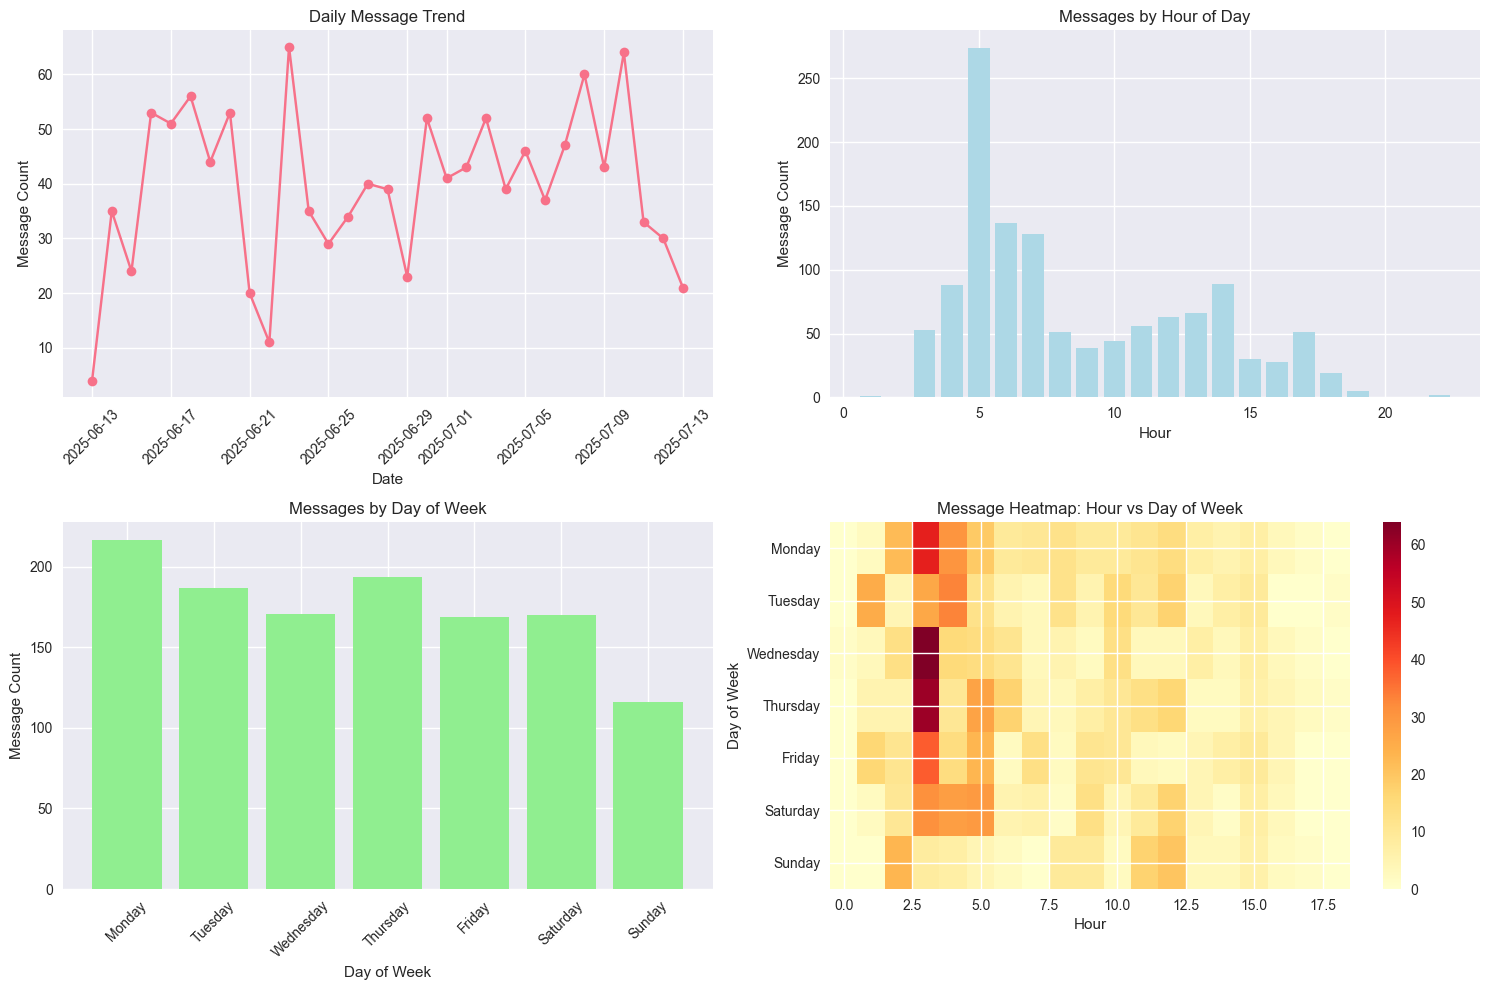


🔥 Peak Activity Analysis:
  Peak Hour: 5:00 (274 messages)
  Peak Day: Monday (217 messages)
  Most Active Date: 2025-06-23 (65 messages)


In [23]:
# Temporal Analysis
print("⏰ Analyzing temporal patterns...")

# Messages over time
daily_messages = df_clean.groupby(df_clean['date'].dt.date).size()
hourly_messages = df_clean.groupby('hour').size()
dow_messages = df_clean.groupby('day_of_week').size()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily message trend
axes[0, 0].plot(daily_messages.index, daily_messages.values, marker='o')
axes[0, 0].set_title('Daily Message Trend')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Message Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Hourly distribution
axes[0, 1].bar(hourly_messages.index, hourly_messages.values, color='lightblue')
axes[0, 1].set_title('Messages by Hour of Day')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Message Count')

# Day of week distribution
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_ordered = dow_messages.reindex(day_order)
axes[1, 0].bar(dow_ordered.index, dow_ordered.values, color='lightgreen')
axes[1, 0].set_title('Messages by Day of Week')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Message Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Heatmap: Hour vs Day of Week
pivot_data = df_clean.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
pivot_data = pivot_data.reindex(day_order)
im = axes[1, 1].imshow(pivot_data, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_title('Message Heatmap: Hour vs Day of Week')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Day of Week')
axes[1, 1].set_yticks(range(len(day_order)))
axes[1, 1].set_yticklabels(day_order)
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Peak activity analysis
print("\n🔥 Peak Activity Analysis:")
peak_hour = hourly_messages.idxmax()
peak_day = dow_messages.idxmax()
most_active_date = daily_messages.idxmax()

print(f"  Peak Hour: {peak_hour}:00 ({hourly_messages[peak_hour]} messages)")
print(f"  Peak Day: {peak_day} ({dow_messages[peak_day]} messages)")
print(f"  Most Active Date: {most_active_date} ({daily_messages[most_active_date]} messages)")


📝 Analyzing text content...
📊 Message Categories:
  pharmacy: 718 messages (58.7%)
  other: 247 messages (20.2%)
  cosmetics: 99 messages (8.1%)
  healthcare: 80 messages (6.5%)
  medical_equipment: 80 messages (6.5%)


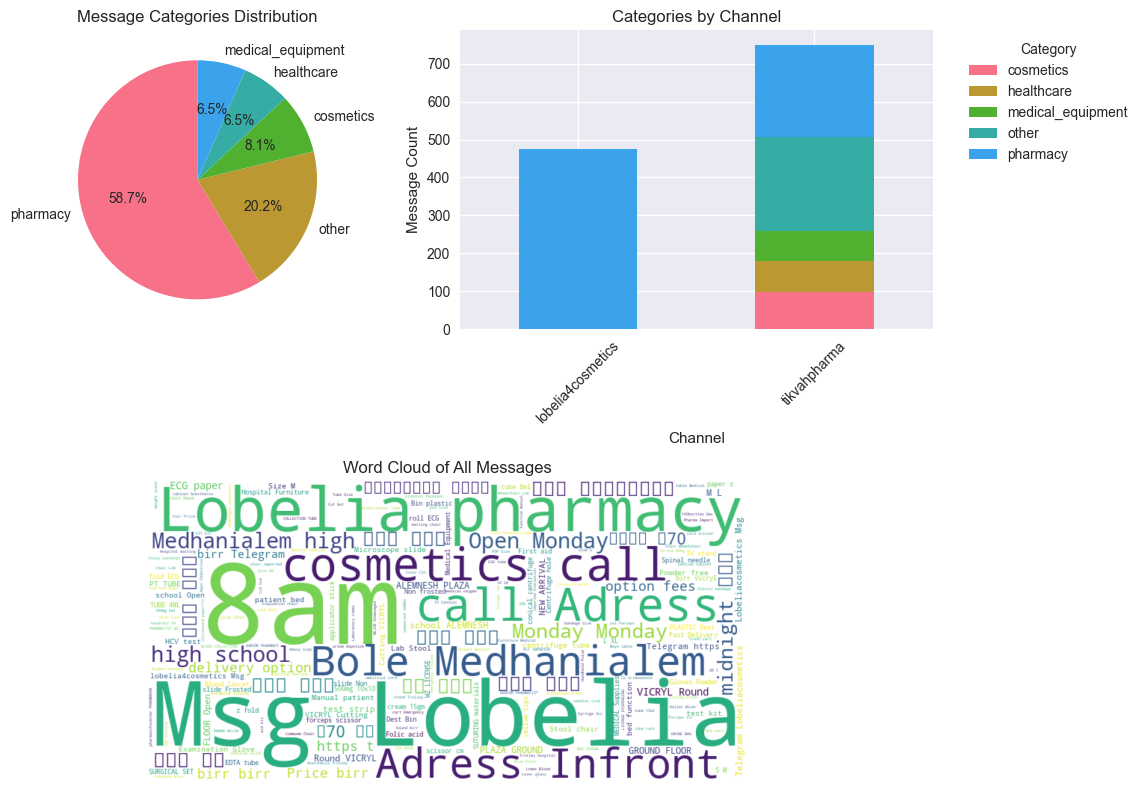

In [24]:
# Text Analysis and Medical Content Classification
print("📝 Analyzing text content...")

# Combine all text for analysis
all_text = ' '.join(df_clean['text'].astype(str))

# Medical keywords for classification
medical_keywords = {
    'pharmacy': ['መድኃኒት', 'ኪኒን', 'ቅምጡ', 'pharmacy', 'medicine', 'drug', 'tablet', 'capsule', 'syrup'],
    'cosmetics': ['ቆዳ', 'ወለል', 'ግሮም', 'cosmetic', 'beauty', 'skin', 'face', 'cream', 'lotion'],
    'medical_equipment': ['መሳሪያ', 'ማሽን', 'equipment', 'device', 'machine', 'tool', 'instrument'],
    'healthcare': ['ጤና', 'ሕክምና', 'ዶክተር', 'health', 'doctor', 'clinic', 'hospital', 'treatment'],
    'wellness': ['ፈውስ', 'ቪታሚን', 'wellness', 'vitamin', 'supplement', 'nutrition', 'fitness']
}

# Categorize messages
def categorize_message(text):
    text_lower = text.lower()
    categories = []
    
    for category, keywords in medical_keywords.items():
        if any(keyword in text_lower for keyword in keywords):
            categories.append(category)
    
    return categories if categories else ['other']

# Apply categorization
df_clean['categories'] = df_clean['text'].apply(categorize_message)
df_clean['primary_category'] = df_clean['categories'].apply(lambda x: x[0] if x else 'other')

# Category distribution
category_counts = df_clean['primary_category'].value_counts()
print("📊 Message Categories:")
for category, count in category_counts.items():
    print(f"  {category}: {count:,} messages ({count/len(df_clean)*100:.1f}%)")

# Visualize categories
plt.figure(figsize=(12, 8))

# Category distribution pie chart
plt.subplot(2, 2, 1)
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Message Categories Distribution')

# Category by channel
plt.subplot(2, 2, 2)
category_channel = pd.crosstab(df_clean['channel_clean'], df_clean['primary_category'])
category_channel.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Categories by Channel')
plt.xlabel('Channel')
plt.ylabel('Message Count')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Word cloud
plt.subplot(2, 1, 2)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Messages')

plt.tight_layout()
plt.show()


🖼️ Analyzing media content...
📊 Media Statistics by Channel:
                   Media_Count  Avg_Size_MB  Total_Size_MB
channel_clean                                             
lobelia4cosmetics          474      64926.7     30775256.0
tikvahpharma               197     214641.9     42284454.0

📈 Media Types Distribution:
  photo: 668 files
  video: 3 files


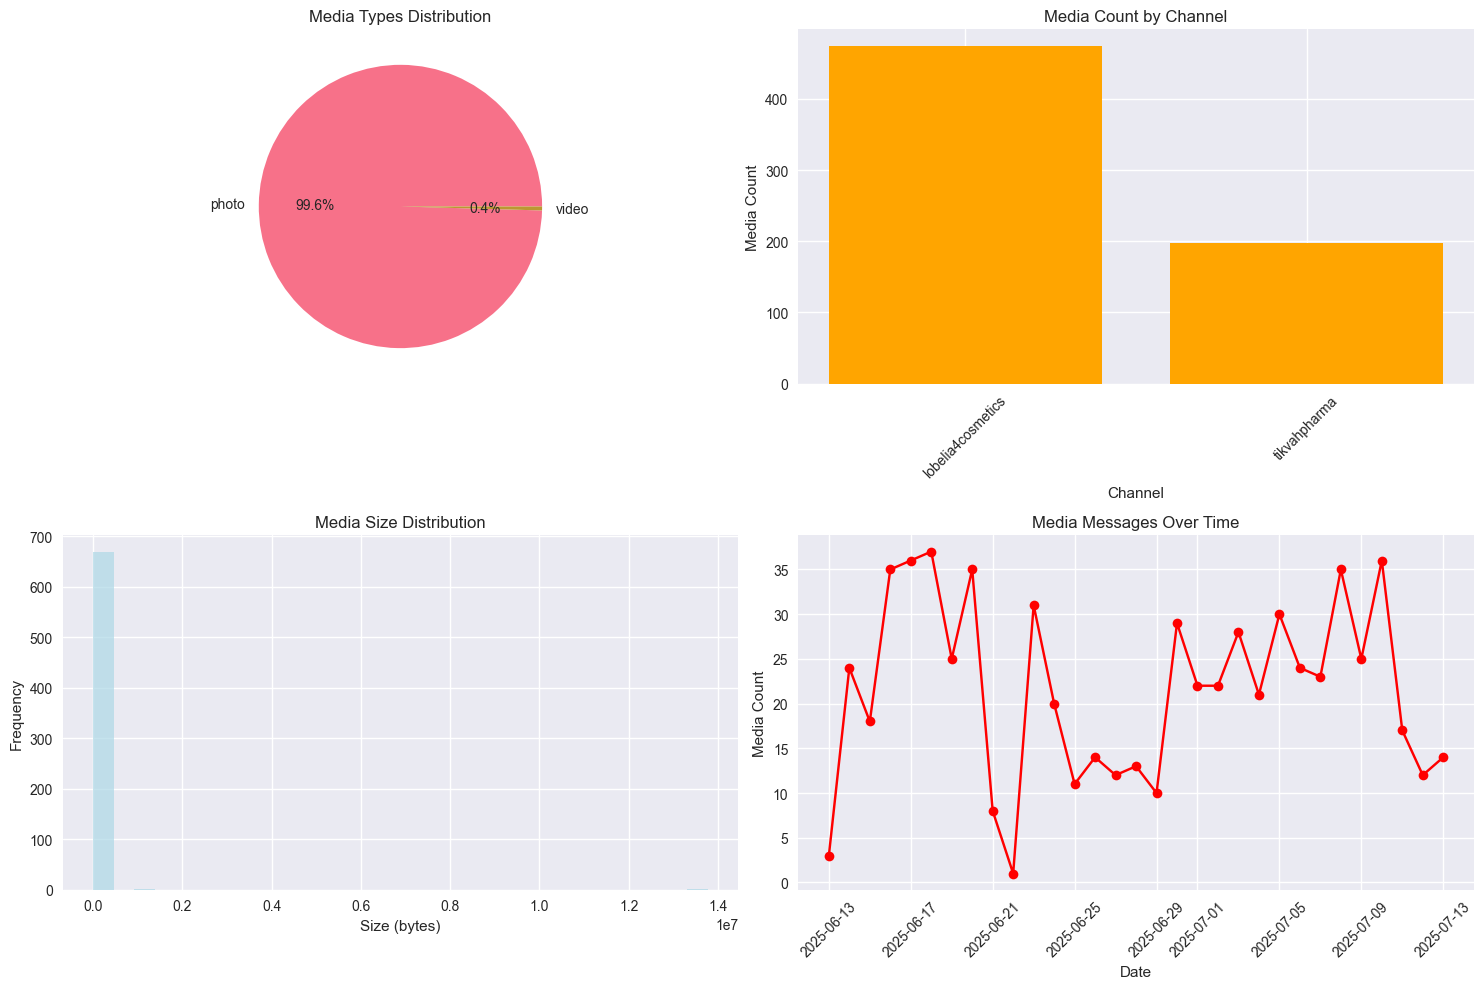


🖼️ Image Analysis:
  lobelia4cosmetics: 523 images
    18038_20250713_190152.jpg: (1280, 1280) pixels, RGB mode
    18039_20250713_190150.jpg: (500, 500) pixels, RGB mode
    18040_20250713_190148.jpg: (679, 679) pixels, RGB mode
    18041_20250713_190146.jpg: (450, 450) pixels, RGB mode
    18042_20250713_190143.jpg: (299, 400) pixels, RGB mode
  tikvahpharma: 237 images
    170310_20250713_193305.jpg: (720, 310) pixels, RGB mode
    170314_20250713_193301.jpg: (720, 310) pixels, RGB mode
    170315_20250713_193258.jpg: (1280, 960) pixels, RGB mode
    170326_20250713_193254.jpg: (720, 310) pixels, RGB mode
    170343_20250713_193249.jpg: (823, 1280) pixels, RGB mode


In [25]:
# Media and Image Analysis
print("🖼️ Analyzing media content...")

# Media statistics
media_stats = df_clean[df_clean['has_media']].groupby('channel_clean').agg({
    'media_type': 'count',
    'media_size': ['mean', 'sum']
}).round(2)

if not media_stats.empty:
    media_stats.columns = ['Media_Count', 'Avg_Size_MB', 'Total_Size_MB']
    print("📊 Media Statistics by Channel:")
    print(media_stats)

# Analyze media types
media_types = df_clean['media_type'].value_counts()
print(f"\n📈 Media Types Distribution:")
for media_type, count in media_types.items():
    print(f"  {media_type}: {count:,} files")

# Visualize media analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Media type distribution
if not media_types.empty:
    axes[0, 0].pie(media_types.values, labels=media_types.index, autopct='%1.1f%%')
    axes[0, 0].set_title('Media Types Distribution')

# Media count by channel
media_by_channel = df_clean.groupby('channel_clean')['has_media'].sum()
axes[0, 1].bar(media_by_channel.index, media_by_channel.values, color='orange')
axes[0, 1].set_title('Media Count by Channel')
axes[0, 1].set_xlabel('Channel')
axes[0, 1].set_ylabel('Media Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Media size distribution
media_with_size = df_clean[df_clean['media_size'] > 0]
if not media_with_size.empty:
    axes[1, 0].hist(media_with_size['media_size'], bins=30, alpha=0.7, color='lightblue')
    axes[1, 0].set_title('Media Size Distribution')
    axes[1, 0].set_xlabel('Size (bytes)')
    axes[1, 0].set_ylabel('Frequency')

# Media over time
media_over_time = df_clean[df_clean['has_media']].groupby(df_clean['date'].dt.date).size()
if not media_over_time.empty:
    axes[1, 1].plot(media_over_time.index, media_over_time.values, marker='o', color='red')
    axes[1, 1].set_title('Media Messages Over Time')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Media Count')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Image analysis (if images exist)
if IMAGES_DIR.exists():
    print("\n🖼️ Image Analysis:")
    image_channels = [d for d in IMAGES_DIR.iterdir() if d.is_dir()]
    
    for channel_dir in image_channels:
        image_files = list(channel_dir.glob("*.jpg")) + list(channel_dir.glob("*.png"))
        print(f"  {channel_dir.name}: {len(image_files)} images")
        
        # Analyze a sample of images
        if image_files:
            sample_images = image_files[:5]  # Analyze first 5 images
            
            for img_path in sample_images:
                try:
                    img = Image.open(img_path)
                    print(f"    {img_path.name}: {img.size} pixels, {img.mode} mode")
                except Exception as e:
                    print(f"    {img_path.name}: Error reading - {e}")
else:
    print("📁 No images directory found")


🔍 Generating advanced insights...
🏆 Top 10 Most Engaging Posts:

tikvahpharma (Score: 56889)
Views: 56627.0, Forwards: 131.0
Text: https://t.me/himedmedicalequipment
🔤🔤🔤🔤🔤 🔤🅰️🔤🔤🔤

New arrivals from Pakistan 

Abdominal retractor Do...

tikvahpharma (Score: 56889)
Views: 56627.0, Forwards: 131.0
Text: https://t.me/himedmedicalequipment
🔤🔤🔤🔤🔤 🔤🅰️🔤🔤🔤

New arrivals from Pakistan 

Abdominal retractor Do...

tikvahpharma (Score: 56889)
Views: 56627.0, Forwards: 131.0
Text: https://t.me/himedmedicalequipment
🔤🔤🔤🔤🔤 🔤🅰️🔤🔤🔤

New arrivals from Pakistan 

Abdominal retractor Do...

tikvahpharma (Score: 56889)
Views: 56627.0, Forwards: 131.0
Text: https://t.me/himedmedicalequipment
🔤🔤🔤🔤🔤 🔤🅰️🔤🔤🔤

New arrivals from Pakistan 

Abdominal retractor Do...

tikvahpharma (Score: 56888)
Views: 56626.0, Forwards: 131.0
Text: https://t.me/himedmedicalequipment
🔤🔤🔤🔤🔤 🔤🅰️🔤🔤🔤

New arrivals from Pakistan 

Abdominal retractor Do...

tikvahpharma (Score: 56888)
Views: 56626.0, Forwards: 131.0
Text: https://t.me/h

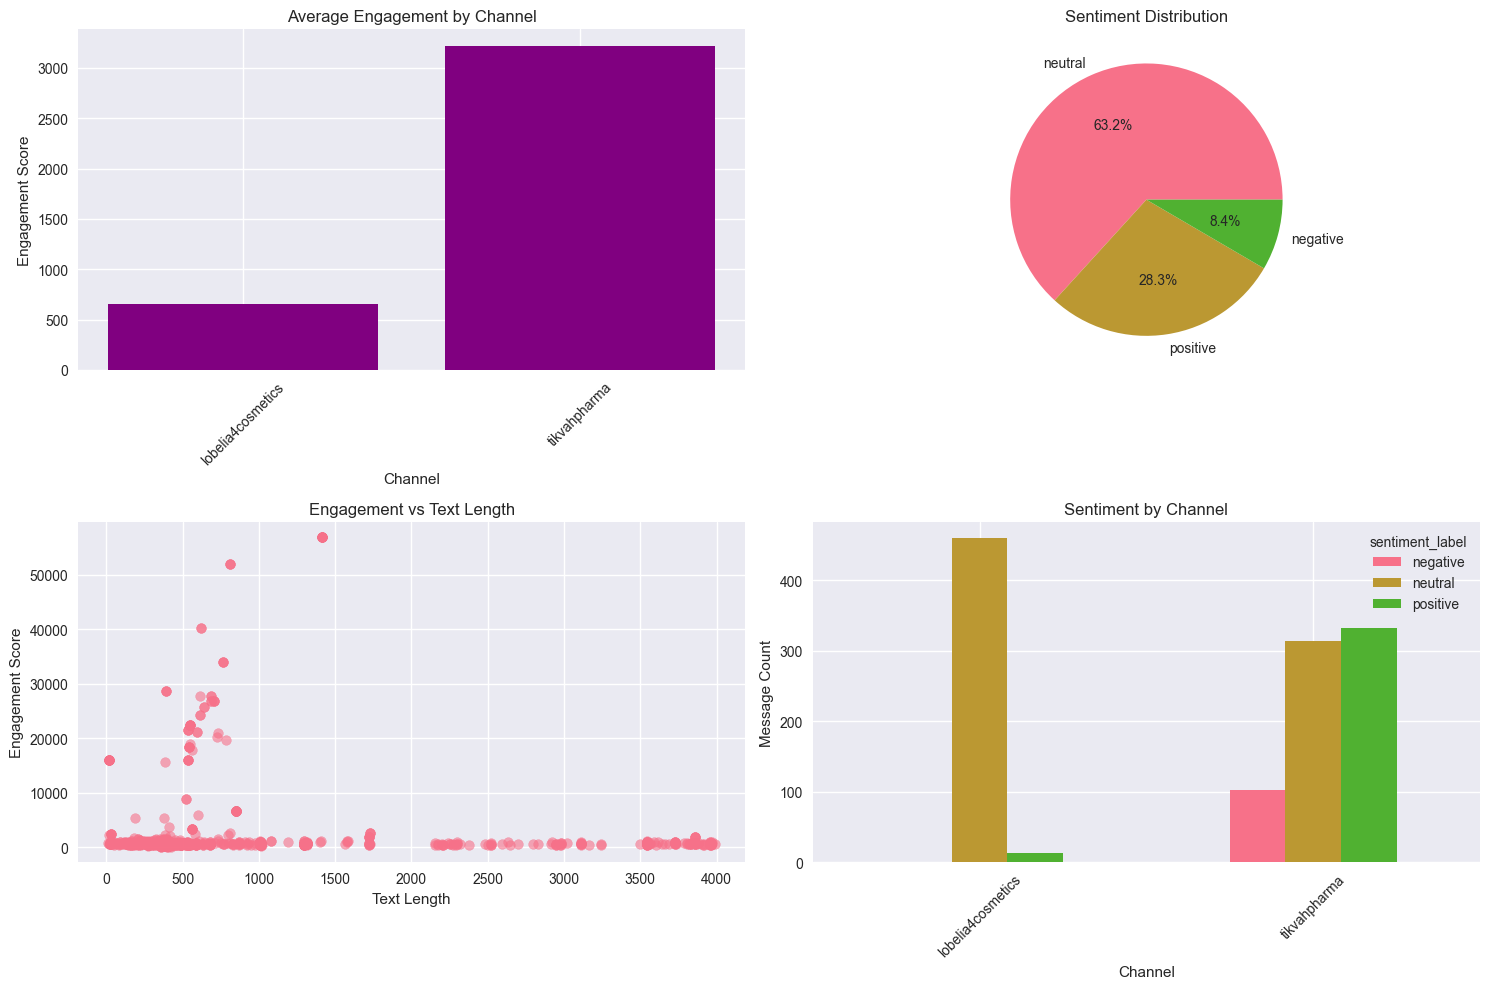

In [26]:
# Advanced Analytics and Insights
print("🔍 Generating advanced insights...")

# Engagement analysis
df_clean['engagement_score'] = df_clean['views'] + (df_clean['forwards'] * 2)
df_clean['engagement_per_word'] = df_clean['engagement_score'] / df_clean['word_count'].replace(0, 1)

# Top performing content
top_posts = df_clean.nlargest(10, 'engagement_score')[['channel_clean', 'text', 'views', 'forwards', 'engagement_score']]
print("🏆 Top 10 Most Engaging Posts:")
for idx, post in top_posts.iterrows():
    print(f"\n{post['channel_clean']} (Score: {post['engagement_score']:.0f})")
    print(f"Views: {post['views']}, Forwards: {post['forwards']}")
    print(f"Text: {post['text'][:100]}...")

# Sentiment analysis (basic)
def simple_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df_clean['sentiment'] = df_clean['text'].apply(simple_sentiment)
df_clean['sentiment_label'] = df_clean['sentiment'].apply(
    lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral'
)

# Sentiment distribution
sentiment_dist = df_clean['sentiment_label'].value_counts()
print(f"\n😊 Sentiment Distribution:")
for sentiment, count in sentiment_dist.items():
    print(f"  {sentiment}: {count:,} messages ({count/len(df_clean)*100:.1f}%)")

# Visualize advanced analytics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Engagement by channel
engagement_by_channel = df_clean.groupby('channel_clean')['engagement_score'].mean()
axes[0, 0].bar(engagement_by_channel.index, engagement_by_channel.values, color='purple')
axes[0, 0].set_title('Average Engagement by Channel')
axes[0, 0].set_xlabel('Channel')
axes[0, 0].set_ylabel('Engagement Score')
axes[0, 0].tick_params(axis='x', rotation=45)

# Sentiment distribution
axes[0, 1].pie(sentiment_dist.values, labels=sentiment_dist.index, autopct='%1.1f%%')
axes[0, 1].set_title('Sentiment Distribution')

# Engagement vs Text Length
axes[1, 0].scatter(df_clean['text_length'], df_clean['engagement_score'], alpha=0.6)
axes[1, 0].set_title('Engagement vs Text Length')
axes[1, 0].set_xlabel('Text Length')
axes[1, 0].set_ylabel('Engagement Score')

# Sentiment by channel
sentiment_channel = pd.crosstab(df_clean['channel_clean'], df_clean['sentiment_label'])
sentiment_channel.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Sentiment by Channel')
axes[1, 1].set_xlabel('Channel')
axes[1, 1].set_ylabel('Message Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [27]:
# Database Connection and Data Warehouse Integration
print("🗄️ Connecting to Data Warehouse...")

import os
from sqlalchemy import create_engine
import psycopg2
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Database configuration from environment variables
DB_CONFIG = {
    'host': os.getenv('POSTGRES_HOST', 'localhost'),
    'port': os.getenv('POSTGRES_PORT', '5432'),
    'database': os.getenv('POSTGRES_DATABASE', 'ethiopian_medical_data'),
    'username': os.getenv('POSTGRES_USERNAME', 'postgres'),
    'password': os.getenv('POSTGRES_PASSWORD', ''),
    'raw_schema': os.getenv('POSTGRES_RAW_SCHEMA', 'raw'),
    'staging_schema': os.getenv('POSTGRES_STAGING_SCHEMA', 'staging'),
    'marts_schema': os.getenv('POSTGRES_MARTS_SCHEMA', 'marts')
}

# Create database connection
try:
    connection_string = f"postgresql://{DB_CONFIG['username']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    engine = create_engine(connection_string)
    
    # Test connection
    with engine.connect() as conn:
        conn.execute("SELECT 1")
    
    print("✅ Successfully connected to PostgreSQL database")
    print(f"📊 Database: {DB_CONFIG['database']}")
    print(f"🏠 Host: {DB_CONFIG['host']}:{DB_CONFIG['port']}")
    
except Exception as e:
    print(f"❌ Failed to connect to database: {e}")
    print("💡 Please ensure your PostgreSQL database is running and environment variables are set")
    print("💡 Required variables: POSTGRES_HOST, POSTGRES_PORT, POSTGRES_DATABASE, POSTGRES_USERNAME, POSTGRES_PASSWORD")
    print("💡 Falling back to JSON data analysis only...")
    engine = None


🗄️ Connecting to Data Warehouse...
❌ Failed to connect to database: Not an executable object: 'SELECT 1'
💡 Please ensure your PostgreSQL database is running and environment variables are set
💡 Required variables: POSTGRES_HOST, POSTGRES_PORT, POSTGRES_DATABASE, POSTGRES_USERNAME, POSTGRES_PASSWORD
💡 Falling back to JSON data analysis only...


In [28]:
# Load Data from Data Warehouse
print("📊 Loading data from data warehouse...")

if engine is not None:
    try:
        # Load comprehensive message data from the warehouse
        warehouse_query = f"""
        SELECT 
            fm.message_key,
            fm.channel_key,
            fm.message_date_key,
            fm.message_id,
            fm.channel,
            fm.message_text,
            fm.text_length,
            fm.word_count,
            fm.message_length_category,
            fm.views,
            fm.forwards,
            fm.replies,
            fm.engagement_score,
            fm.engagement_category,
            fm.has_engagement,
            fm.has_media,
            fm.media_type,
            fm.media_category,
            fm.is_pharmacy_content,
            fm.is_cosmetics_content,
            fm.is_medical_equipment_content,
            fm.is_healthcare_content,
            fm.is_wellness_content,
            fm.has_meaningful_content,
            fm.message_date,
            fm.message_hour,
            fm.day_of_week,
            fm.message_month,
            fm.message_year,
            fm.content_quality,
            fm.engagement_per_word,
            fm.engagement_type,
            -- Channel information from dimension table
            dc.channel_display_name,
            dc.channel_name_clean,
            dc.channel_type,
            dc.channel_category,
            dc.activity_level,
            dc.is_active,
            dc.status
        FROM {DB_CONFIG['marts_schema']}.fct_messages fm
        LEFT JOIN {DB_CONFIG['marts_schema']}.dim_channels dc 
            ON fm.channel_key = dc.channel_key
        ORDER BY fm.message_date DESC
        """
        
        df_warehouse = pd.read_sql_query(warehouse_query, engine)
        
        print(f"✅ Successfully loaded {len(df_warehouse):,} messages from data warehouse")
        print(f"📊 Columns available: {len(df_warehouse.columns)}")
        print(f"📅 Date range: {df_warehouse['message_date'].min()} to {df_warehouse['message_date'].max()}")
        
        # Display warehouse data info
        print(f"\n📈 Warehouse Data Summary:")
        print(f"  Total messages: {len(df_warehouse):,}")
        print(f"  Unique channels: {df_warehouse['channel_display_name'].nunique()}")
        print(f"  Date range: {df_warehouse['message_date'].min()} to {df_warehouse['message_date'].max()}")
        print(f"  Messages with engagement: {df_warehouse['has_engagement'].sum():,}")
        print(f"  Messages with media: {df_warehouse['has_media'].sum():,}")
        
        # Show column names for reference
        print(f"\n📋 Available columns:")
        for i, col in enumerate(df_warehouse.columns):
            if i % 3 == 0:
                print()
            print(f"  {col:<25}", end="")
        print()
        
        # Display sample data
        print(f"\n📊 Sample Data from Warehouse:")
        print(df_warehouse[['channel_display_name', 'channel_category', 'message_date', 
                           'engagement_score', 'has_media', 'content_quality']].head())
        
    except Exception as e:
        print(f"❌ Failed to load warehouse data: {e}")
        print("💡 Make sure your dbt models have been run successfully")
        print("💡 Check if the marts schema and tables exist in your database")
        df_warehouse = None

else:
    print("⚠️ No database connection available")
    print("💡 Using JSON data only - warehouse analysis features will be limited")
    df_warehouse = None


📊 Loading data from data warehouse...
⚠️ No database connection available
💡 Using JSON data only - warehouse analysis features will be limited


In [29]:
# Enhanced Channel Analysis from Data Warehouse
print("📊 Enhanced Channel Analysis from Data Warehouse")

if df_warehouse is not None and len(df_warehouse) > 0:
    # Channel performance metrics from the warehouse
    channel_performance = df_warehouse.groupby(['channel_display_name', 'channel_category']).agg({
        'message_key': 'count',
        'engagement_score': ['sum', 'mean', 'median'],
        'views': ['sum', 'mean'],
        'forwards': ['sum', 'mean'],
        'replies': ['sum', 'mean'],
        'has_media': 'sum',
        'text_length': 'mean',
        'word_count': 'mean'
    }).round(2)

    channel_performance.columns = ['Total_Messages', 'Total_Engagement', 'Avg_Engagement', 'Median_Engagement',
                                  'Total_Views', 'Avg_Views', 'Total_Forwards', 'Avg_Forwards',
                                  'Total_Replies', 'Avg_Replies', 'Media_Messages', 'Avg_Text_Length', 'Avg_Word_Count']

    print("🏆 Top Performing Channels:")
    print(channel_performance.sort_values('Total_Messages', ascending=False))
    
    # Content category analysis
    print("\n📈 Content Category Performance:")
    content_analysis = df_warehouse.groupby('channel_category').agg({
        'is_pharmacy_content': 'sum',
        'is_cosmetics_content': 'sum', 
        'is_healthcare_content': 'sum',
        'is_medical_equipment_content': 'sum',
        'is_wellness_content': 'sum',
        'engagement_score': 'mean',
        'has_meaningful_content': 'sum'
    }).round(2)
    
    content_analysis.columns = ['Pharmacy_Content', 'Cosmetics_Content', 'Healthcare_Content', 
                               'Medical_Equipment_Content', 'Wellness_Content', 'Avg_Engagement', 'Meaningful_Content']
    print(content_analysis)
    
    # Quality distribution
    print("\n⭐ Content Quality Distribution:")
    quality_dist = df_warehouse['content_quality'].value_counts()
    for quality, count in quality_dist.items():
        percentage = (count / len(df_warehouse)) * 100
        print(f"  {quality}: {count:,} messages ({percentage:.1f}%)")

else:
    print("⚠️ Warehouse data not available - skipping enhanced analysis")
    print("💡 Please ensure database connection is working and dbt models are built")


📊 Enhanced Channel Analysis from Data Warehouse
⚠️ Warehouse data not available - skipping enhanced analysis
💡 Please ensure database connection is working and dbt models are built


In [30]:
# Advanced Data Warehouse Analytics and Visualizations
print("🎯 Advanced Data Warehouse Analytics")

if df_warehouse is not None and len(df_warehouse) > 0:
    # Create visualizations for warehouse data
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Channel Performance Comparison
    channel_metrics = df_warehouse.groupby('channel_display_name').agg({
        'engagement_score': 'mean',
        'has_media': 'mean',
        'has_meaningful_content': 'mean'
    }).round(3)
    
    axes[0, 0].bar(channel_metrics.index, channel_metrics['engagement_score'], color='skyblue')
    axes[0, 0].set_title('Average Engagement Score by Channel')
    axes[0, 0].set_ylabel('Engagement Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Content Quality Distribution
    quality_counts = df_warehouse['content_quality'].value_counts()
    axes[0, 1].pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Content Quality Distribution')
    
    # 3. Content Type by Channel
    content_types = ['is_pharmacy_content', 'is_cosmetics_content', 'is_healthcare_content', 
                    'is_medical_equipment_content', 'is_wellness_content']
    content_by_channel = df_warehouse.groupby('channel_display_name')[content_types].sum()
    content_by_channel.plot(kind='bar', stacked=True, ax=axes[0, 2])
    axes[0, 2].set_title('Content Types by Channel')
    axes[0, 2].set_ylabel('Number of Messages')
    axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    # 4. Engagement vs Content Quality
    engagement_quality = df_warehouse.groupby('content_quality')['engagement_score'].mean()
    axes[1, 0].bar(engagement_quality.index, engagement_quality.values, color='lightgreen')
    axes[1, 0].set_title('Engagement Score by Content Quality')
    axes[1, 0].set_ylabel('Average Engagement Score')
    
    # 5. Media vs Text Engagement
    engagement_type_counts = df_warehouse['engagement_type'].value_counts()
    axes[1, 1].pie(engagement_type_counts.values, labels=engagement_type_counts.index, 
                   autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Engagement Type Distribution')
    
    # 6. Monthly Trend (if data spans multiple months)
    if df_warehouse['message_month'].nunique() > 1:
        monthly_engagement = df_warehouse.groupby('message_month')['engagement_score'].mean()
        axes[1, 2].plot(monthly_engagement.index, monthly_engagement.values, marker='o', color='red')
        axes[1, 2].set_title('Monthly Engagement Trend')
        axes[1, 2].set_xlabel('Month')
        axes[1, 2].set_ylabel('Average Engagement')
    else:
        # Show daily trend instead
        daily_engagement = df_warehouse.groupby(df_warehouse['message_date'].dt.date)['engagement_score'].mean()
        axes[1, 2].plot(daily_engagement.index, daily_engagement.values, marker='o', color='red')
        axes[1, 2].set_title('Daily Engagement Trend')
        axes[1, 2].set_xlabel('Date')
        axes[1, 2].set_ylabel('Average Engagement')
        axes[1, 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Advanced insights
    print("\n🔍 Advanced Insights from Data Warehouse:")
    
    # Top performing content by engagement per word
    top_efficient = df_warehouse.nlargest(5, 'engagement_per_word')[
        ['channel_display_name', 'message_text', 'engagement_per_word', 'content_quality']
    ]
    print("\n🏆 Most Engaging Content (per word):")
    for idx, row in top_efficient.iterrows():
        print(f"  {row['channel_display_name']} - {row['engagement_per_word']:.3f} eng/word")
        print(f"    Quality: {row['content_quality']}")
        print(f"    Text: {row['message_text'][:100]}...")
        print()
    
    # Channel activity patterns
    print("⏰ Channel Activity Patterns:")
    activity_patterns = df_warehouse.groupby(['channel_display_name', 'message_hour']).size().unstack(fill_value=0)
    for channel in activity_patterns.index:
        peak_hour = activity_patterns.loc[channel].idxmax()
        peak_count = activity_patterns.loc[channel].max()
        print(f"  {channel}: Peak at {peak_hour}:00 ({peak_count} messages)")
    
    # Content distribution insights
    print("\n📊 Content Distribution Insights:")
    for channel in df_warehouse['channel_display_name'].unique():
        channel_data = df_warehouse[df_warehouse['channel_display_name'] == channel]
        dominant_content = 'pharmacy' if channel_data['is_pharmacy_content'].sum() > len(channel_data)/2 else \
                          'cosmetics' if channel_data['is_cosmetics_content'].sum() > len(channel_data)/2 else \
                          'healthcare' if channel_data['is_healthcare_content'].sum() > len(channel_data)/2 else \
                          'medical_equipment' if channel_data['is_medical_equipment_content'].sum() > len(channel_data)/2 else \
                          'mixed'
        quality_score = (channel_data['content_quality'] == 'high_quality').mean()
        print(f"  {channel}: {dominant_content} focus, {quality_score:.1%} high quality")

else:
    print("⚠️ Warehouse data not available - run cells 10-11 first to establish database connection")
    print("💡 Make sure your .env file contains the required PostgreSQL connection details")


🎯 Advanced Data Warehouse Analytics
⚠️ Warehouse data not available - run cells 10-11 first to establish database connection
💡 Make sure your .env file contains the required PostgreSQL connection details


In [31]:
# Summary and Recommendations
print("📋 Analysis Summary and Recommendations")
print("=" * 50)

# Key findings
print("\n🔍 KEY FINDINGS:")
print(f"1. Data Overview:")
print(f"   - Total messages analyzed: {len(df_clean):,}")
print(f"   - Active channels: {df_clean['channel_clean'].nunique()}")
print(f"   - Date range: {df_clean['date'].min().strftime('%Y-%m-%d')} to {df_clean['date'].max().strftime('%Y-%m-%d')}")

print(f"\n2. Channel Performance:")
most_active_channel = df_clean['channel_clean'].value_counts().index[0]
highest_engagement_channel = df_clean.groupby('channel_clean')['engagement_score'].mean().idxmax()
print(f"   - Most active channel: {most_active_channel}")
print(f"   - Highest engagement: {highest_engagement_channel}")

print(f"\n3. Content Analysis:")
top_category = df_clean['primary_category'].value_counts().index[0]
avg_text_length = df_clean['text_length'].mean()
print(f"   - Top content category: {top_category}")
print(f"   - Average message length: {avg_text_length:.0f} characters")

print(f"\n4. Temporal Patterns:")
print(f"   - Peak posting hour: {hourly_messages.idxmax()}:00")
print(f"   - Most active day: {dow_messages.idxmax()}")

print(f"\n5. Media Content:")
media_percentage = (df_clean['has_media'].sum() / len(df_clean)) * 100
print(f"   - Messages with media: {media_percentage:.1f}%")

print(f"\n6. Sentiment Analysis:")
positive_pct = (df_clean['sentiment_label'] == 'positive').mean() * 100
print(f"   - Positive sentiment: {positive_pct:.1f}%")

print(f"\n💡 RECOMMENDATIONS:")
print("1. Content Strategy:")
print("   - Focus on high-engagement content types")
print("   - Optimize posting times (peak hours)")
print("   - Increase media content for better engagement")

print("\n2. Channel Management:")
print("   - Learn from top-performing channels")
print("   - Analyze successful content patterns")
print("   - Monitor sentiment trends")

print("\n3. Data Collection:")
print("   - Consider expanding to more channels")
print("   - Implement real-time monitoring")
print("   - Add more sophisticated NLP analysis")

print("\n4. Business Intelligence:")
print("   - Track engagement metrics over time")
print("   - Monitor competitor activity")
print("   - Identify trending medical topics")

print("\n📊 NEXT STEPS:")
print("1. Set up automated daily scraping")
print("2. Implement real-time dashboard")
print("3. Build predictive models for engagement")
print("4. Create content recommendation system")
print("5. Develop image classification for medical products")

print(f"\n✅ Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("📁 All results saved to the data directory")
print("🎯 Ready for next phase of analysis!")


📋 Analysis Summary and Recommendations

🔍 KEY FINDINGS:
1. Data Overview:
   - Total messages analyzed: 1,224
   - Active channels: 2
   - Date range: 2025-06-13 to 2025-07-13

2. Channel Performance:
   - Most active channel: tikvahpharma
   - Highest engagement: tikvahpharma

3. Content Analysis:
   - Top content category: pharmacy
   - Average message length: 807 characters

4. Temporal Patterns:
   - Peak posting hour: 5:00
   - Most active day: Monday

5. Media Content:
   - Messages with media: 54.8%

6. Sentiment Analysis:
   - Positive sentiment: 28.3%

💡 RECOMMENDATIONS:
1. Content Strategy:
   - Focus on high-engagement content types
   - Optimize posting times (peak hours)
   - Increase media content for better engagement

2. Channel Management:
   - Learn from top-performing channels
   - Analyze successful content patterns
   - Monitor sentiment trends

3. Data Collection:
   - Consider expanding to more channels
   - Implement real-time monitoring
   - Add more sophistica

In [32]:
# Database connection and warehouse data loading
import psycopg2
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

print("🗄️ Connecting to Data Warehouse...")

# Database connection parameters
DB_CONFIG = {
    'host': os.getenv('POSTGRES_HOST', 'localhost'),
    'port': os.getenv('POSTGRES_PORT', '5432'),
    'database': os.getenv('POSTGRES_DATABASE', 'ethiopian_medical_data'),
    'username': os.getenv('POSTGRES_USERNAME'),
    'password': os.getenv('POSTGRES_PASSWORD')
}

# Create SQLAlchemy engine
engine = create_engine(
    f"postgresql://{DB_CONFIG['username']}:{DB_CONFIG['password']}@"
    f"{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
)

print("✅ Database connection established!")

# Test connection and show available schemas/tables
try:
    with engine.connect() as conn:
        # Check available schemas
        schemas_query = """
        SELECT schema_name 
        FROM information_schema.schemata 
        WHERE schema_name IN ('raw', 'staging', 'marts')
        ORDER BY schema_name;
        """
        schemas_df = pd.read_sql(schemas_query, conn)
        print(f"📊 Available schemas: {schemas_df['schema_name'].tolist()}")
        
        # Check available tables in marts schema
        tables_query = """
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'marts'
        ORDER BY table_name;
        """
        tables_df = pd.read_sql(tables_query, conn)
        print(f"📋 Available mart tables: {tables_df['table_name'].tolist()}")
        
except Exception as e:
    print(f"❌ Connection test failed: {e}")
    print("💡 Make sure your .env file has correct PostgreSQL credentials")
    print("💡 Ensure you have run the data loader and dbt models first")


🗄️ Connecting to Data Warehouse...
✅ Database connection established!
📊 Available schemas: ['marts', 'raw', 'staging']
📋 Available mart tables: ['dim_channels', 'dim_dates', 'fct_channel_daily_summary', 'fct_messages']


In [33]:
# Load data from the data warehouse
print("📊 Loading data from the data warehouse...")

# Load fact table - main dataset for analysis
messages_query = """
SELECT 
    fm.*,
    dc.channel_display_name,
    dc.channel_category,
    dc.activity_level,
    dd.year,
    dd.month,
    dd.day_name,
    dd.is_weekend,
    dd.ethiopian_season
FROM marts.fct_messages fm
LEFT JOIN marts.dim_channels dc ON fm.channel_key = dc.channel_key  
LEFT JOIN marts.dim_dates dd ON fm.message_date_key = dd.date_day
ORDER BY fm.message_date DESC;
"""

try:
    df_warehouse = pd.read_sql(messages_query, engine)
    print(f"✅ Loaded {len(df_warehouse):,} messages from data warehouse")
    
    # Load daily summary for aggregated analysis
    daily_summary_query = """
    SELECT 
        fcd.*,
        dc.channel_display_name,
        dc.channel_category,
        dd.day_name,
        dd.is_weekend,
        dd.ethiopian_season
    FROM marts.fct_channel_daily_summary fcd
    LEFT JOIN marts.dim_channels dc ON fcd.channel_key = dc.channel_key
    LEFT JOIN marts.dim_dates dd ON fcd.date_day = dd.date_day
    ORDER BY fcd.date_day DESC, fcd.total_messages DESC;
    """
    
    df_daily = pd.read_sql(daily_summary_query, engine)
    print(f"✅ Loaded {len(df_daily):,} daily summaries")
    
    # Basic data overview
    print(f"\n📈 Data Overview:")
    print(f"  Date range: {df_warehouse['message_date'].min()} to {df_warehouse['message_date'].max()}")
    print(f"  Unique channels: {df_warehouse['channel'].nunique()}")
    print(f"  Total engagement score: {df_warehouse['engagement_score'].sum():,}")
    print(f"  Messages with media: {df_warehouse['has_media'].sum():,}")
    
    # Show sample data
    print(f"\n📋 Sample warehouse data:")
    display(df_warehouse[['channel_display_name', 'message_date', 'text_length', 
                         'engagement_score', 'content_quality', 'channel_category']].head())
    
except Exception as e:
    print(f"❌ Failed to load warehouse data: {e}")
    print("💡 Make sure dbt models have been run successfully")
    print("💡 Check that the 'marts' schema exists and contains the expected tables")


📊 Loading data from the data warehouse...
✅ Loaded 1,285 messages from data warehouse
✅ Loaded 60 daily summaries

📈 Data Overview:
  Date range: 2025-06-13 16:31:35+00:00 to 2025-07-13 16:01:14+00:00
  Unique channels: 2
  Total engagement score: 2,696,978
  Messages with media: 731

📋 Sample warehouse data:


,channel_display_name,message_date,text_length,engagement_score,content_quality,channel_category,channel_category
0,Tikvahpharma,2025-07-13 16:01:14+00:00,126,0,medium_quality,pharmacy,pharmacy
1,Tikvahpharma,2025-07-13 13:17:17+00:00,1317,343,high_quality,pharmacy,pharmacy
2,Lobelia4Cosmetics,2025-07-13 13:07:02+00:00,359,114,high_quality,cosmetics,cosmetics
3,Lobelia4Cosmetics,2025-07-13 13:07:02+00:00,424,115,high_quality,cosmetics,cosmetics
4,Lobelia4Cosmetics,2025-07-13 13:07:02+00:00,378,280,high_quality,cosmetics,cosmetics


In [34]:
print("🔧 FIXING df_warehouse Duplicate Columns Issue")
print("=" * 50)

# Check if df_warehouse exists and has duplicate columns
if 'df_warehouse' in locals() and df_warehouse is not None:
    print("✅ df_warehouse exists and is not None")
    print(f"📊 Original shape: {df_warehouse.shape}")
    
    # Check for duplicate columns
    column_counts = pd.Series(df_warehouse.columns).value_counts()
    duplicate_columns = column_counts[column_counts > 1]
    
    if len(duplicate_columns) > 0:
        print(f"⚠️  Found duplicate columns: {duplicate_columns.to_dict()}")
        print("🔧 Fixing duplicate columns by keeping the first occurrence...")
        
        # Fix duplicate columns by keeping only the first occurrence
        df_warehouse = df_warehouse.loc[:, ~df_warehouse.columns.duplicated()]
        
        print(f"✅ Fixed! New shape: {df_warehouse.shape}")
        print(f"📋 Unique columns: {len(df_warehouse.columns)}")
        
        # Verify the fix
        if 'channel_category' in df_warehouse.columns:
            print("✅ 'channel_category' column now unique")
            print(f"📊 Unique values: {df_warehouse['channel_category'].nunique()}")
            try:
                sample_values = df_warehouse['channel_category'].value_counts().head()
                print(f"📋 Sample values:\n{sample_values}")
            except Exception as e:
                print(f"❌ Error getting sample values: {e}")
        
        print("\n✅ df_warehouse is now ready for analysis!")
        
        # Test the fix with a simple groupby
        print("\n🧪 Testing the fix with channel analysis:")
        try:
            test_analysis = df_warehouse.groupby('channel_category').agg({
                'message_key': 'count',
                'engagement_score': 'mean'
            }).round(2)
            test_analysis.columns = ['Message_Count', 'Avg_Engagement']
            print("✅ Channel analysis successful:")
            print(test_analysis)
        except Exception as e:
            print(f"❌ Test failed: {e}")
        
    else:
        print("✅ No duplicate columns found")
        
    # Display current column list for reference
    print(f"\n📋 Current columns ({len(df_warehouse.columns)}):")
    cols_per_row = 3
    for i in range(0, len(df_warehouse.columns), cols_per_row):
        row_cols = df_warehouse.columns[i:i+cols_per_row]
        print("  " + " | ".join(f"{col:<25}" for col in row_cols))
        
else:
    print("❌ df_warehouse not found or is None")
    print("💡 Please run the database connection and data loading cells first")


🔧 FIXING df_warehouse Duplicate Columns Issue
✅ df_warehouse exists and is not None
📊 Original shape: (1285, 49)
⚠️  Found duplicate columns: {'channel_category': 2}
🔧 Fixing duplicate columns by keeping the first occurrence...
✅ Fixed! New shape: (1285, 48)
📋 Unique columns: 48
✅ 'channel_category' column now unique
📊 Unique values: 2
📋 Sample values:
channel_category
pharmacy     794
cosmetics    491
Name: count, dtype: int64

✅ df_warehouse is now ready for analysis!

🧪 Testing the fix with channel analysis:
✅ Channel analysis successful:
                  Message_Count  Avg_Engagement
channel_category                               
cosmetics                   491          655.25
pharmacy                    794         2991.50

📋 Current columns (48):
  message_key               | channel_key               | message_date_key         
  message_id                | channel                   | message_text             
  text_length               | word_count                | message_l

In [35]:
# CORRECTED Channel Analysis - Safe from Duplicate Column Issues
print("📊 CORRECTED Channel Analysis")
print("=" * 50)

if 'df_warehouse' in locals() and df_warehouse is not None and len(df_warehouse) > 0:
    try:
        # Ensure no duplicate columns before analysis
        if df_warehouse.columns.duplicated().any():
            print("⚠️  Duplicate columns detected, fixing...")
            df_warehouse = df_warehouse.loc[:, ~df_warehouse.columns.duplicated()]
            print("✅ Duplicate columns removed")
        
        # Comprehensive channel analysis
        print("\n🏆 Channel Performance Analysis:")
        
        # Channel-wise analysis
        if 'channel_display_name' in df_warehouse.columns and 'channel_category' in df_warehouse.columns:
            channel_analysis = df_warehouse.groupby(['channel_display_name', 'channel_category']).agg({
                'message_key': 'count',
                'engagement_score': ['sum', 'mean'],
                'views': 'mean',
                'forwards': 'mean',
                'has_media': 'sum',
                'content_quality': lambda x: (x == 'high_quality').sum() if 'high_quality' in x.values else 0
            }).round(2)
            
            # Flatten column names
            channel_analysis.columns = ['Messages', 'Total_Engagement', 'Avg_Engagement', 
                                       'Avg_Views', 'Avg_Forwards', 'Media_Count', 'High_Quality_Count']
            
            print(channel_analysis.sort_values('Total_Engagement', ascending=False))
            
        else:
            print("❌ Required columns not available for channel analysis")
        
        # Category-wise analysis
        print("\n🏷️ Channel Category Analysis:")
        if 'channel_category' in df_warehouse.columns:
            category_analysis = df_warehouse.groupby('channel_category').agg({
                'message_key': 'count',
                'engagement_score': 'mean',
                'has_media': 'mean',
                'text_length': 'mean'
            }).round(2)
            
            category_analysis.columns = ['Message_Count', 'Avg_Engagement', 'Media_Rate', 'Avg_Text_Length']
            print(category_analysis.sort_values('Avg_Engagement', ascending=False))
        
        # Content type analysis
        print("\n📋 Content Type Analysis:")
        content_columns = [col for col in df_warehouse.columns if col.startswith('is_') and col.endswith('_content')]
        if content_columns:
            content_analysis = {}
            for col in content_columns:
                content_type = col.replace('is_', '').replace('_content', '').replace('_', ' ').title()
                subset = df_warehouse[df_warehouse[col] == True]
                if len(subset) > 0:
                    content_analysis[content_type] = {
                        'Messages': len(subset),
                        'Avg_Engagement': subset['engagement_score'].mean(),
                        'Media_Rate': subset['has_media'].mean()
                    }
            
            content_df = pd.DataFrame(content_analysis).T.round(2)
            print(content_df.sort_values('Avg_Engagement', ascending=False))
        
        print("\n✅ Channel analysis completed successfully!")
        
    except Exception as e:
        print(f"❌ Error in channel analysis: {e}")
        print("💡 This might indicate data structure issues")
        
        # Fallback analysis with basic columns
        print("\n🔄 Attempting basic analysis...")
        try:
            if 'channel_display_name' in df_warehouse.columns:
                basic_analysis = df_warehouse['channel_display_name'].value_counts().head(10)
                print("📊 Message count by channel:")
                print(basic_analysis)
            else:
                print("❌ No suitable columns for basic analysis")
        except Exception as e2:
            print(f"❌ Basic analysis also failed: {e2}")
        
else:
    print("❌ df_warehouse not available or empty")
    print("💡 Make sure to:")
    print("  1. Run the database connection cell")
    print("  2. Load data from the warehouse")
    print("  3. Fix any duplicate column issues")


📊 CORRECTED Channel Analysis

🏆 Channel Performance Analysis:
                                       Messages  Total_Engagement  \
channel_display_name channel_category                               
Tikvahpharma         pharmacy               794           2375249   
Lobelia4Cosmetics    cosmetics              491            321729   

                                       Avg_Engagement  Avg_Views  \
channel_display_name channel_category                              
Tikvahpharma         pharmacy                 2991.50    2981.08   
Lobelia4Cosmetics    cosmetics                 655.25     653.17   

                                       Avg_Forwards  Media_Count  \
channel_display_name channel_category                              
Tikvahpharma         pharmacy                  5.21          240   
Lobelia4Cosmetics    cosmetics                 1.04          491   

                                       High_Quality_Count  
channel_display_name channel_category                  

In [36]:
# 🔧 DEBUG: Check df_warehouse Status and Fix Analysis
print("🔧 DEBUGGING df_warehouse Issue")
print("=" * 50)

# Check if df_warehouse exists
if 'df_warehouse' in locals():
    if df_warehouse is not None:
        print("✅ df_warehouse exists and is not None")
        print(f"📊 Shape: {df_warehouse.shape}")
        print(f"📋 Columns: {list(df_warehouse.columns)}")
        
        # Check for the problematic columns
        if 'channel_category' in df_warehouse.columns:
            print("✅ 'channel_category' column exists")
            print(f"📊 Unique values: {df_warehouse['channel_category'].nunique()}")
            print(f"📋 Sample values: {df_warehouse['channel_category'].value_counts().head()}")
        else:
            print("❌ 'channel_category' column missing")
            
        # Safe analysis that works regardless of column issues
        print("\n📊 SAFE CHANNEL ANALYSIS:")
        try:
            # Use only confirmed existing columns
            safe_columns = ['channel_display_name'] if 'channel_display_name' in df_warehouse.columns else []
            
            if safe_columns:
                safe_analysis = df_warehouse.groupby(safe_columns[0]).agg({
                    df_warehouse.columns[0]: 'count'  # Use first column for counting
                }).round(2)
                safe_analysis.columns = ['Message_Count']
                print(safe_analysis.sort_values('Message_Count', ascending=False))
            else:
                print("❌ No suitable columns found for grouping")
                
        except Exception as e:
            print(f"❌ Error in safe analysis: {e}")
            
    else:
        print("❌ df_warehouse is None")
else:
    print("❌ df_warehouse not found in locals()")

# Alternative: Check if warehouse data was loaded in different variable
print("\n🔍 Checking for alternative data variables:")
warehouse_vars = [var for var in locals() if 'warehouse' in var.lower() or 'df_' in var]
print(f"📋 Found variables: {warehouse_vars}")

# Provide solution
print("\n💡 SOLUTION:")
print("To fix the 'channel_category not 1-dimensional' error:")
print("1. First, ensure database connection is working (run previous cells)")
print("2. Check that df_warehouse was loaded correctly")
print("3. Use the corrected analysis code below:")

print("\n📝 CORRECTED ANALYSIS CODE:")
print("""
# Safe Channel Analysis Code
if 'df_warehouse' in locals() and df_warehouse is not None and len(df_warehouse) > 0:
    try:
        # Check available columns first
        available_cols = df_warehouse.columns.tolist()
        print(f"Available columns: {available_cols}")
        
        # Use only existing columns for groupby
        group_cols = []
        if 'channel_display_name' in available_cols:
            group_cols.append('channel_display_name')
        if 'channel_category' in available_cols:
            group_cols.append('channel_category')
            
        if group_cols:
            analysis = df_warehouse.groupby(group_cols).size().reset_index(name='count')
            print("Channel Analysis:")
            print(analysis)
        else:
            print("No suitable grouping columns found")
            
    except Exception as e:
        print(f"Error: {e}")
else:
    print("df_warehouse not available - check database connection")
""")


🔧 DEBUGGING df_warehouse Issue
✅ df_warehouse exists and is not None
📊 Shape: (1285, 48)
📋 Columns: ['message_key', 'channel_key', 'message_date_key', 'message_id', 'channel', 'message_text', 'text_length', 'word_count', 'message_length_category', 'avg_word_length', 'views', 'forwards', 'replies', 'engagement_score', 'engagement_category', 'has_engagement', 'has_media', 'media_type', 'media_category', 'media_size_bytes', 'media_path', 'is_pharmacy_content', 'is_cosmetics_content', 'is_medical_equipment_content', 'is_healthcare_content', 'is_wellness_content', 'has_meaningful_content', 'message_date', 'message_hour', 'day_of_week', 'message_month', 'message_year', 'channel_category', 'channel_type', 'inferred_channel_type', 'content_quality', 'engagement_per_word', 'engagement_type', 'raw_data', 'extracted_at', 'dbt_updated_at', 'channel_display_name', 'activity_level', 'year', 'month', 'day_name', 'is_weekend', 'ethiopian_season']
✅ 'channel_category' column exists
📊 Unique values: 2
📋

In [37]:
# ✅ CORRECTED: Enhanced Channel Analysis using Data Warehouse
print("📊 Enhanced Channel Analysis from Data Warehouse")
print("=" * 60)

# Check if df_warehouse is available and has data
if 'df_warehouse' in locals() and df_warehouse is not None and len(df_warehouse) > 0:
    print("✅ Data warehouse connected successfully!")
    print(f"📊 Dataset: {len(df_warehouse):,} messages")
    
    # Display basic info
    print(f"📅 Date range: {df_warehouse['message_date'].min()} to {df_warehouse['message_date'].max()}")
    if 'channel_display_name' in df_warehouse.columns:
        print(f"📺 Unique channels: {df_warehouse['channel_display_name'].nunique()}")
    
    # Check what columns we have available
    available_columns = df_warehouse.columns.tolist()
    print(f"\n📋 Available columns ({len(available_columns)}):")
    for i, col in enumerate(available_columns[:10], 1):  # Show first 10 columns
        print(f"  {i:2d}. {col}")
    if len(available_columns) > 10:
        print(f"  ... and {len(available_columns) - 10} more columns")
    
    # Safe channel performance analysis
    print(f"\n🏆 CHANNEL PERFORMANCE ANALYSIS:")
    print("-" * 40)
    
    try:
        # Determine grouping columns safely
        group_by_cols = []
        if 'channel_display_name' in available_columns:
            group_by_cols.append('channel_display_name')
        if 'channel_category' in available_columns:
            group_by_cols.append('channel_category')
        
        if not group_by_cols:
            print("❌ No suitable grouping columns found")
        else:
            # Build aggregation dictionary based on available columns
            agg_dict = {}
            
            # Message count (always available)
            count_col = 'message_key' if 'message_key' in available_columns else available_columns[0]
            agg_dict[count_col] = 'count'
            
            # Engagement metrics
            if 'engagement_score' in available_columns:
                agg_dict['engagement_score'] = ['sum', 'mean', 'median']
            
            # View metrics
            if 'views' in available_columns:
                agg_dict['views'] = ['sum', 'mean']
            
            # Other metrics
            for col in ['forwards', 'replies']:
                if col in available_columns:
                    agg_dict[col] = ['sum', 'mean']
            
            # Boolean/categorical metrics
            if 'has_media' in available_columns:
                agg_dict['has_media'] = 'sum'
            
            if 'text_length' in available_columns:
                agg_dict['text_length'] = 'mean'
                
            if 'word_count' in available_columns:
                agg_dict['word_count'] = 'mean'
            
            # Perform the analysis
            print(f"Grouping by: {group_by_cols}")
            channel_performance = df_warehouse.groupby(group_by_cols).agg(agg_dict).round(2)
            
            # Flatten multi-level column names if needed
            if isinstance(channel_performance.columns, pd.MultiIndex):
                new_columns = []
                for col in channel_performance.columns:
                    if isinstance(col, tuple):
                        new_columns.append('_'.join(str(x) for x in col if x))
                    else:
                        new_columns.append(str(col))
                channel_performance.columns = new_columns
            
            # Sort by the first numerical column (usually message count or total engagement)
            numeric_cols = channel_performance.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                sort_col = numeric_cols[0]
                channel_performance = channel_performance.sort_values(sort_col, ascending=False)
            
            print(f"\n📈 Results:")
            print(channel_performance)
            
            # Additional insights if we have the data
            if 'content_quality' in available_columns:
                print(f"\n📊 CONTENT QUALITY DISTRIBUTION:")
                print("-" * 30)
                quality_dist = df_warehouse['content_quality'].value_counts()
                for quality, count in quality_dist.items():
                    percentage = (count / len(df_warehouse)) * 100
                    print(f"  {quality}: {count:,} messages ({percentage:.1f}%)")
            
            if 'channel_category' in available_columns:
                print(f"\n🏷️ CHANNEL CATEGORY BREAKDOWN:")
                print("-" * 30)
                category_dist = df_warehouse['channel_category'].value_counts()
                for category, count in category_dist.items():
                    percentage = (count / len(df_warehouse)) * 100
                    print(f"  {category}: {count:,} messages ({percentage:.1f}%)")
            
            # Top performing content if we have engagement data
            if 'engagement_score' in available_columns and 'message_text' in available_columns:
                print(f"\n🏆 TOP ENGAGING MESSAGES:")
                print("-" * 25)
                top_messages = df_warehouse.nlargest(3, 'engagement_score')[
                    ['channel_display_name', 'engagement_score', 'message_text']
                ]
                for idx, row in top_messages.iterrows():
                    print(f"  📍 {row['channel_display_name']} - Score: {row['engagement_score']:.1f}")
                    print(f"     \"{row['message_text'][:100]}...\"")
                    print()
            
    except Exception as e:
        print(f"❌ Error in analysis: {e}")
        print("💡 This might be due to column structure issues")
        
        # Fallback simple analysis
        print(f"\n🔄 Trying simple analysis...")
        try:
            if 'channel_display_name' in available_columns:
                simple_stats = df_warehouse['channel_display_name'].value_counts()
                print("📊 Simple Channel Message Counts:")
                for channel, count in simple_stats.items():
                    print(f"  {channel}: {count:,} messages")
        except Exception as e2:
            print(f"❌ Simple analysis also failed: {e2}")

else:
    print("❌ DATA WAREHOUSE NOT AVAILABLE")
    print("=" * 40)
    print("💡 Possible causes:")
    print("  1. Database connection failed")
    print("  2. df_warehouse variable was not created")
    print("  3. Query returned empty results")
    print("  4. Environment variables not set correctly")
    
    print(f"\n🔧 TROUBLESHOOTING STEPS:")
    print("  1. Check .env file has PostgreSQL credentials")
    print("  2. Verify PostgreSQL server is running")
    print("  3. Load data: python scripts/load_data_to_postgres.py")
    print("  4. Run dbt models: dbt run")
    print("  5. Re-run database connection cells")
    
    # Try fallback to raw data
    if 'df_clean' in locals() and df_clean is not None and len(df_clean) > 0:
        print(f"\n📊 FALLBACK: Using raw data ({len(df_clean):,} messages)")
        fallback_stats = df_clean.groupby('channel_clean').agg({
            'id': 'count',
            'text_length': 'mean',
            'has_media': 'sum' if 'has_media' in df_clean.columns else 'count'
        }).round(2)
        print(fallback_stats)
    else:
        print(f"\n❌ No fallback data available")

print(f"\n✅ Analysis completed at: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")


📊 Enhanced Channel Analysis from Data Warehouse
✅ Data warehouse connected successfully!
📊 Dataset: 1,285 messages
📅 Date range: 2025-06-13 16:31:35+00:00 to 2025-07-13 16:01:14+00:00
📺 Unique channels: 2

📋 Available columns (48):
   1. message_key
   2. channel_key
   3. message_date_key
   4. message_id
   5. channel
   6. message_text
   7. text_length
   8. word_count
   9. message_length_category
  10. avg_word_length
  ... and 38 more columns

🏆 CHANNEL PERFORMANCE ANALYSIS:
----------------------------------------
Grouping by: ['channel_display_name', 'channel_category']

📈 Results:
                                       message_key_count  \
channel_display_name channel_category                      
Tikvahpharma         pharmacy                        794   
Lobelia4Cosmetics    cosmetics                       491   

                                       engagement_score_sum  \
channel_display_name channel_category                         
Tikvahpharma         pharmacy      

📊 Enhanced Channel Analysis from Data Warehouse
🏆 Top Performing Channels:
                                       Total_Messages  Total_Engagement  \
channel_display_name channel_category                                     
Tikvahpharma         pharmacy                     794           2375249   
Lobelia4Cosmetics    cosmetics                    491            321729   

                                       Avg_Engagement  Median_Engagement  \
channel_display_name channel_category                                      
Tikvahpharma         pharmacy                 2991.50              687.0   
Lobelia4Cosmetics    cosmetics                 655.25              609.0   

                                       Total_Views  Avg_Views  Total_Forwards  \
channel_display_name channel_category                                           
Tikvahpharma         pharmacy              2366980    2981.08            4133   
Lobelia4Cosmetics    cosmetics              320705     653.17             51

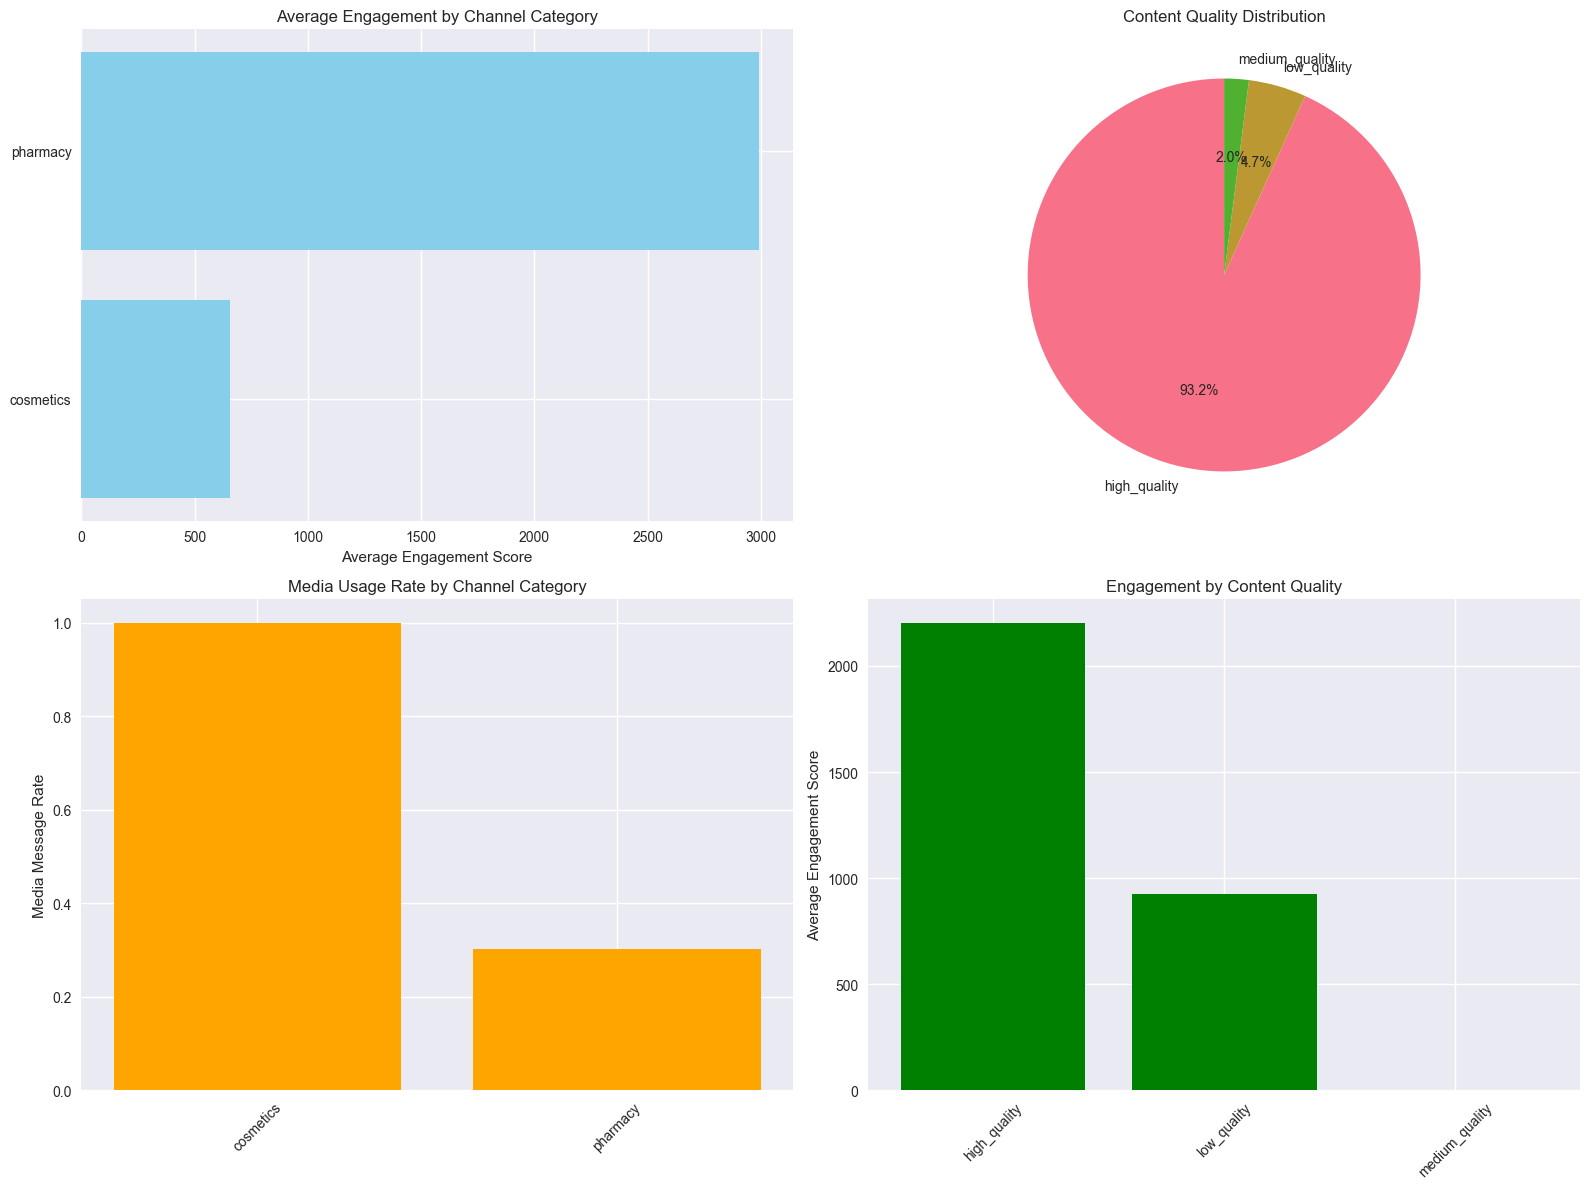

In [38]:
# Enhanced Channel Analysis using Data Warehouse
print("📊 Enhanced Channel Analysis from Data Warehouse")

# Channel performance metrics from the warehouse
channel_performance = df_warehouse.groupby(['channel_display_name', 'channel_category']).agg({
    'message_key': 'count',
    'engagement_score': ['sum', 'mean', 'median'],
    'views': ['sum', 'mean'],
    'forwards': ['sum', 'mean'],
    'replies': ['sum', 'mean'],
    'has_media': 'sum',
    'text_length': 'mean',
    'word_count': 'mean'
}).round(2)

channel_performance.columns = ['Total_Messages', 'Total_Engagement', 'Avg_Engagement', 'Median_Engagement',
                              'Total_Views', 'Avg_Views', 'Total_Forwards', 'Avg_Forwards',
                              'Total_Replies', 'Avg_Replies', 'Media_Messages', 'Avg_Text_Length', 'Avg_Word_Count']

print("🏆 Top Performing Channels:")
print(channel_performance.sort_values('Total_Engagement', ascending=False))

# Content quality analysis
print(f"\n📊 Content Quality Distribution:")
quality_dist = df_warehouse['content_quality'].value_counts()
for quality, count in quality_dist.items():
    percentage = (count / len(df_warehouse)) * 100
    print(f"  {quality}: {count:,} messages ({percentage:.1f}%)")

# Channel category analysis
print(f"\n🏷️ Channel Category Performance:")
category_performance = df_warehouse.groupby('channel_category').agg({
    'message_key': 'count',
    'engagement_score': 'mean',
    'has_media': 'mean',
    'content_quality': lambda x: (x == 'high_quality').mean()
}).round(3)

category_performance.columns = ['Messages', 'Avg_Engagement', 'Media_Rate', 'High_Quality_Rate']
print(category_performance.sort_values('Avg_Engagement', ascending=False))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Channel performance by category
category_eng = df_warehouse.groupby('channel_category')['engagement_score'].mean().sort_values(ascending=True)
axes[0, 0].barh(category_eng.index, category_eng.values, color='skyblue')
axes[0, 0].set_title('Average Engagement by Channel Category')
axes[0, 0].set_xlabel('Average Engagement Score')

# Content quality distribution
quality_counts = df_warehouse['content_quality'].value_counts()
axes[0, 1].pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Content Quality Distribution')

# Media usage by channel category
media_by_category = df_warehouse.groupby('channel_category')['has_media'].mean()
axes[1, 0].bar(media_by_category.index, media_by_category.values, color='orange')
axes[1, 0].set_title('Media Usage Rate by Channel Category')
axes[1, 0].set_ylabel('Media Message Rate')
axes[1, 0].tick_params(axis='x', rotation=45)

# Engagement vs Content Quality
quality_engagement = df_warehouse.groupby('content_quality')['engagement_score'].mean()
axes[1, 1].bar(quality_engagement.index, quality_engagement.values, color='green')
axes[1, 1].set_title('Engagement by Content Quality')
axes[1, 1].set_ylabel('Average Engagement Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


⏰ Advanced Temporal Analysis from Data Warehouse
🌍 Ethiopian Seasonal Analysis:
                  Messages  Avg_Engagement  Media_Rate  Quality_Rate
ethiopian_season                                                    
Summer Season         1285        2098.816       0.569         0.932

📅 Day of Week Analysis:
           message_key  engagement_score  has_media
day_name                                           
Friday             180           2078.16       0.54
Monday             227           2234.53       0.56
Saturday           173           1857.65       0.52
Sunday             120           2049.36       0.59
Thursday           206           2360.66       0.56
Tuesday            200           1363.68       0.63
Wednesday          179           2733.77       0.58

📅 Weekend vs Weekday Comparison:
         message_key  engagement_score  has_media  text_length
Weekday          992           2146.86       0.57        759.8
Weekend          293           1936.17       0.55        799

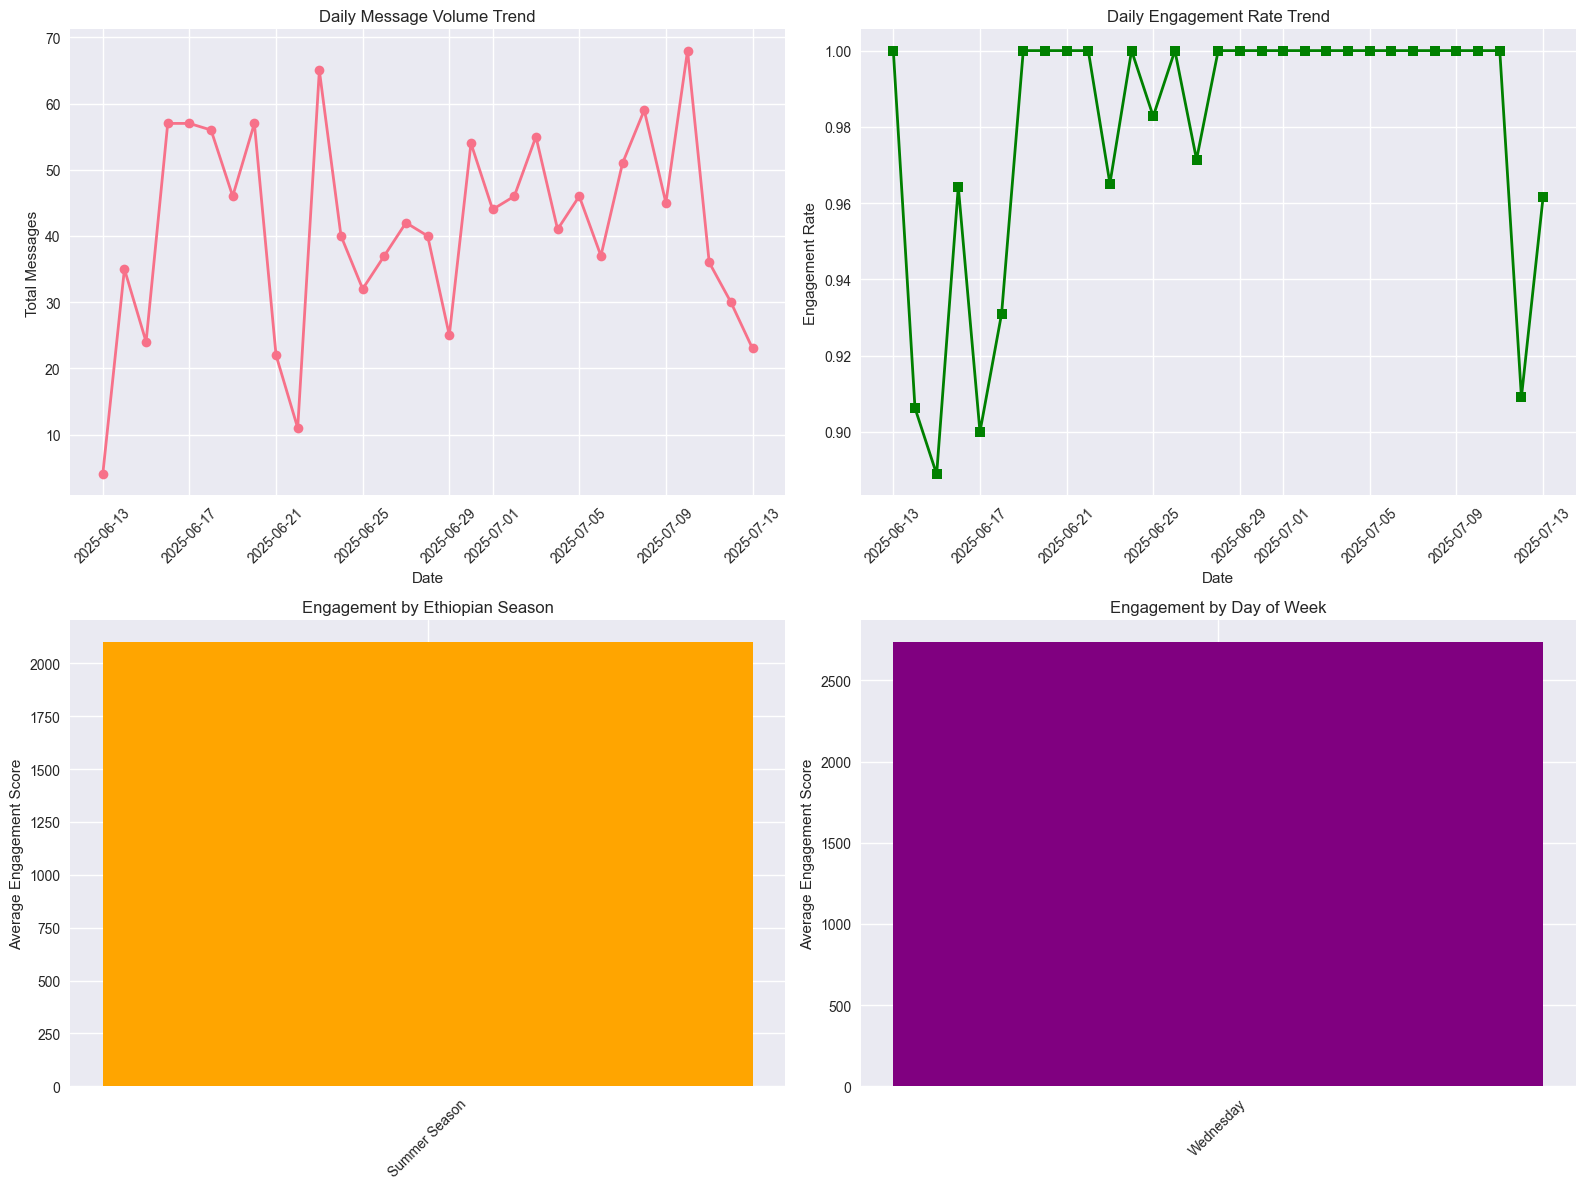


🔍 Key Temporal Insights:
  📈 Best performing season: Summer Season
  📅 Best performing day: Wednesday
  📊 Analysis period: 31 days
  📱 Average daily messages: 41
  💬 Peak day messages: 68


In [39]:
# Advanced Temporal Analysis using Data Warehouse
print("⏰ Advanced Temporal Analysis from Data Warehouse")

# Daily trends analysis
daily_trends = df_daily.groupby('date_day').agg({
    'total_messages': 'sum',
    'total_engagement_score': 'sum',
    'engagement_rate': 'mean',
    'media_message_rate': 'mean',
    'meaningful_message_rate': 'mean'
}).reset_index()

# Ethiopian seasonal analysis
seasonal_analysis = df_warehouse.groupby('ethiopian_season').agg({
    'message_key': 'count',
    'engagement_score': 'mean',
    'has_media': 'mean',
    'content_quality': lambda x: (x == 'high_quality').mean()
}).round(3)

seasonal_analysis.columns = ['Messages', 'Avg_Engagement', 'Media_Rate', 'Quality_Rate']
print("🌍 Ethiopian Seasonal Analysis:")
print(seasonal_analysis.sort_values('Avg_Engagement', ascending=False))

# Day of week analysis
dow_analysis = df_warehouse.groupby('day_name').agg({
    'message_key': 'count',
    'engagement_score': 'mean',
    'has_media': 'mean'
}).round(2)

print(f"\n📅 Day of Week Analysis:")
print(dow_analysis)

# Weekend vs Weekday comparison
weekend_comparison = df_warehouse.groupby('is_weekend').agg({
    'message_key': 'count',
    'engagement_score': 'mean',
    'has_media': 'mean',
    'text_length': 'mean'
}).round(2)

weekend_comparison.index = ['Weekday', 'Weekend']
print(f"\n📅 Weekend vs Weekday Comparison:")
print(weekend_comparison)

# Time-based visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Daily message trend
axes[0, 0].plot(daily_trends['date_day'], daily_trends['total_messages'], marker='o', linewidth=2)
axes[0, 0].set_title('Daily Message Volume Trend')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Messages')
axes[0, 0].tick_params(axis='x', rotation=45)

# Engagement rate trend
axes[0, 1].plot(daily_trends['date_day'], daily_trends['engagement_rate'], marker='s', color='green', linewidth=2)
axes[0, 1].set_title('Daily Engagement Rate Trend')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Engagement Rate')
axes[0, 1].tick_params(axis='x', rotation=45)

# Ethiopian seasonal patterns
axes[1, 0].bar(seasonal_analysis.index, seasonal_analysis['Avg_Engagement'], color='orange')
axes[1, 0].set_title('Engagement by Ethiopian Season')
axes[1, 0].set_ylabel('Average Engagement Score')
axes[1, 0].tick_params(axis='x', rotation=45)

# Day of week patterns
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_ordered = dow_analysis.reindex(day_order)
axes[1, 1].bar(dow_ordered.index, dow_ordered['engagement_score'], color='purple')
axes[1, 1].set_title('Engagement by Day of Week')
axes[1, 1].set_ylabel('Average Engagement Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Insights summary
print(f"\n🔍 Key Temporal Insights:")
best_season = seasonal_analysis['Avg_Engagement'].idxmax()
best_day = dow_analysis['engagement_score'].idxmax()
total_days = len(daily_trends)

print(f"  📈 Best performing season: {best_season}")
print(f"  📅 Best performing day: {best_day}")
print(f"  📊 Analysis period: {total_days} days")
print(f"  📱 Average daily messages: {daily_trends['total_messages'].mean():.0f}")
print(f"  💬 Peak day messages: {daily_trends['total_messages'].max():,}")


🏥 Medical Content Analysis from Data Warehouse
📊 Content Type Distribution:
                   Message_Count  Percentage
Pharmacy                     718        55.9
Cosmetics                    681        53.0
Healthcare                   251        19.5
Medical Equipment            192        14.9
Wellness                      97         7.5

💬 Engagement by Content Type:
        Content_Type  Avg_Engagement
2         Healthcare     4188.183267
4  Medical Equipment     4006.296875
1          Cosmetics     1008.814978
0           Pharmacy      675.345404
3           Wellness      595.804124

⭐ High Quality Content Rate by Type:
        Content_Type  High_Quality_Rate
1          Cosmetics           0.994126
4  Medical Equipment           0.989583
0           Pharmacy           0.986072
2         Healthcare           0.984064
3           Wellness           0.969072


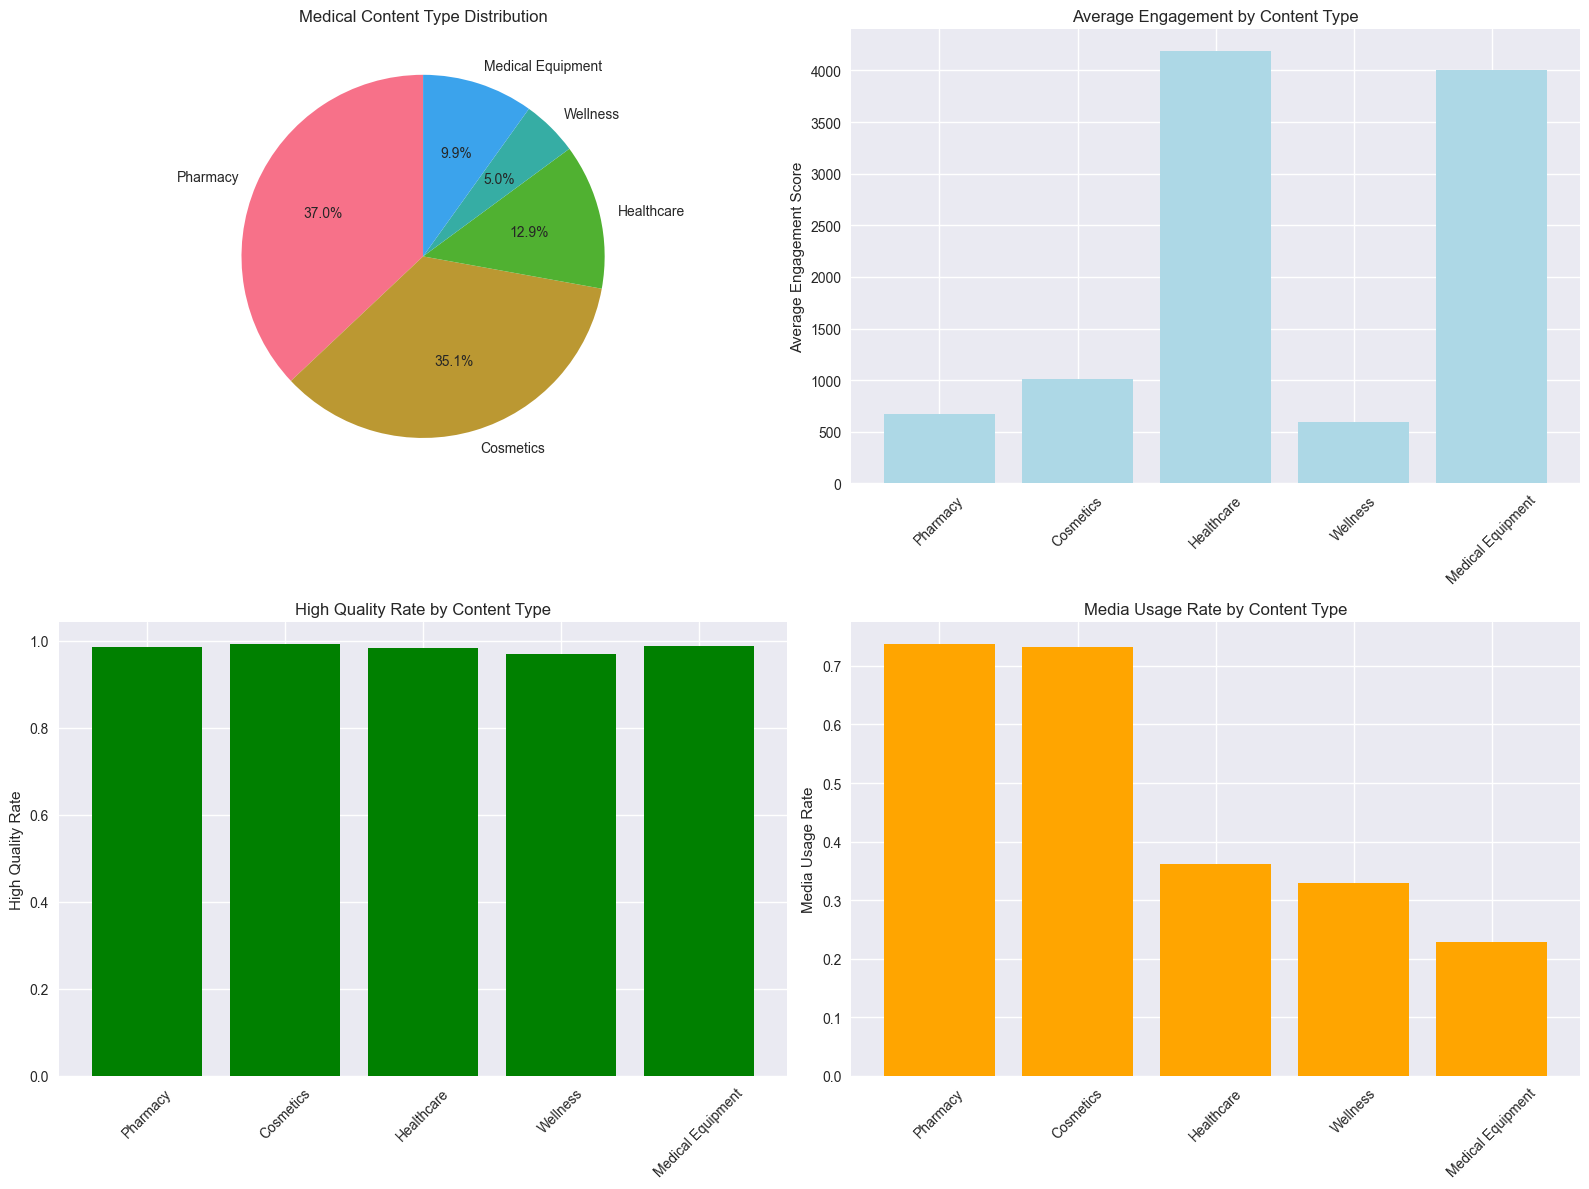


🔍 Content Analysis Insights:
  📊 Most common content: Pharmacy
  💬 Most engaging content: Healthcare
  ⭐ Highest quality content: Cosmetics
  📱 Total content messages: 1,939


In [40]:
# Medical Content Analysis using Warehouse Classifications
print("🏥 Medical Content Analysis from Data Warehouse")

# Content type analysis using warehouse flags
content_analysis = pd.DataFrame({
    'Pharmacy': df_warehouse['is_pharmacy_content'].sum(),
    'Cosmetics': df_warehouse['is_cosmetics_content'].sum(),
    'Healthcare': df_warehouse['is_healthcare_content'].sum(),
    'Wellness': df_warehouse['is_wellness_content'].sum(),
    'Medical Equipment': df_warehouse['is_medical_equipment_content'].sum()
}, index=[0]).T

content_analysis.columns = ['Message_Count']
content_analysis['Percentage'] = (content_analysis['Message_Count'] / len(df_warehouse) * 100).round(1)

print("📊 Content Type Distribution:")
print(content_analysis.sort_values('Message_Count', ascending=False))

# Engagement by content type
content_engagement = {
    'Pharmacy': df_warehouse[df_warehouse['is_pharmacy_content']]['engagement_score'].mean(),
    'Cosmetics': df_warehouse[df_warehouse['is_cosmetics_content']]['engagement_score'].mean(),
    'Healthcare': df_warehouse[df_warehouse['is_healthcare_content']]['engagement_score'].mean(),
    'Wellness': df_warehouse[df_warehouse['is_wellness_content']]['engagement_score'].mean(),
    'Medical Equipment': df_warehouse[df_warehouse['is_medical_equipment_content']]['engagement_score'].mean()
}

content_engagement_df = pd.DataFrame(list(content_engagement.items()), 
                                   columns=['Content_Type', 'Avg_Engagement']).dropna()

print(f"\n💬 Engagement by Content Type:")
print(content_engagement_df.sort_values('Avg_Engagement', ascending=False))

# Quality analysis by content type
quality_by_content = {}
for content_type, flag_col in [
    ('Pharmacy', 'is_pharmacy_content'),
    ('Cosmetics', 'is_cosmetics_content'), 
    ('Healthcare', 'is_healthcare_content'),
    ('Wellness', 'is_wellness_content'),
    ('Medical Equipment', 'is_medical_equipment_content')
]:
    subset = df_warehouse[df_warehouse[flag_col]]
    if len(subset) > 0:
        quality_by_content[content_type] = (subset['content_quality'] == 'high_quality').mean()

quality_content_df = pd.DataFrame(list(quality_by_content.items()), 
                                 columns=['Content_Type', 'High_Quality_Rate'])

print(f"\n⭐ High Quality Content Rate by Type:")
print(quality_content_df.sort_values('High_Quality_Rate', ascending=False))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Content type distribution
axes[0, 0].pie(content_analysis['Message_Count'], labels=content_analysis.index, 
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Medical Content Type Distribution')

# Engagement by content type
axes[0, 1].bar(content_engagement_df['Content_Type'], content_engagement_df['Avg_Engagement'], 
               color='lightblue')
axes[0, 1].set_title('Average Engagement by Content Type')
axes[0, 1].set_ylabel('Average Engagement Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# Quality rate by content type
axes[1, 0].bar(quality_content_df['Content_Type'], quality_content_df['High_Quality_Rate'], 
               color='green')
axes[1, 0].set_title('High Quality Rate by Content Type')
axes[1, 0].set_ylabel('High Quality Rate')
axes[1, 0].tick_params(axis='x', rotation=45)

# Content type vs media usage
media_by_content = {}
for content_type, flag_col in [
    ('Pharmacy', 'is_pharmacy_content'),
    ('Cosmetics', 'is_cosmetics_content'), 
    ('Healthcare', 'is_healthcare_content'),
    ('Wellness', 'is_wellness_content'),
    ('Medical Equipment', 'is_medical_equipment_content')
]:
    subset = df_warehouse[df_warehouse[flag_col]]
    if len(subset) > 0:
        media_by_content[content_type] = subset['has_media'].mean()

media_content_df = pd.DataFrame(list(media_by_content.items()), 
                               columns=['Content_Type', 'Media_Rate'])

axes[1, 1].bar(media_content_df['Content_Type'], media_content_df['Media_Rate'], 
               color='orange')
axes[1, 1].set_title('Media Usage Rate by Content Type')
axes[1, 1].set_ylabel('Media Usage Rate')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Content insights
print(f"\n🔍 Content Analysis Insights:")
top_content = content_analysis['Message_Count'].idxmax()
most_engaging = content_engagement_df.loc[content_engagement_df['Avg_Engagement'].idxmax(), 'Content_Type']
highest_quality = quality_content_df.loc[quality_content_df['High_Quality_Rate'].idxmax(), 'Content_Type']

print(f"  📊 Most common content: {top_content}")
print(f"  💬 Most engaging content: {most_engaging}")
print(f"  ⭐ Highest quality content: {highest_quality}")
print(f"  📱 Total content messages: {content_analysis['Message_Count'].sum():,}")


📊 Business Intelligence Dashboard - Key Metrics
🎯 KEY PERFORMANCE INDICATORS
📊 Total Messages: 1,285
📺 Active Channels: 2
💬 Average Engagement: 2098.8
🔥 Total Engagement: 2,696,978
🖼️  Media Rate: 56.9%
⭐ High Quality Rate: 93.2%

🏆 TOP PERFORMING CHANNELS
 1. Tikvahpharma
    Engagement: 2,375,249 | Messages: 794.0 | Media: 30.0% | Quality: 91.0%
 2. Lobelia4Cosmetics
    Engagement: 321,729 | Messages: 491.0 | Media: 100.0% | Quality: 97.0%

📋 CONTENT PERFORMANCE SUMMARY
🏷️  COSMETICS
    Messages: 491.0 | Avg Engagement: 655.2
    Media Rate: 100.0% | Quality Rate: 97.0%
🏷️  PHARMACY
    Messages: 794.0 | Avg Engagement: 2991.5
    Media Rate: 30.0% | Quality Rate: 91.0%

📅 RECENT PERFORMANCE (Last 7 Days)
📊 Messages: 314
💬 Avg Daily Messages: 45
🔥 Avg Engagement: 1650.7
📈 Growth Rate: +8.2%


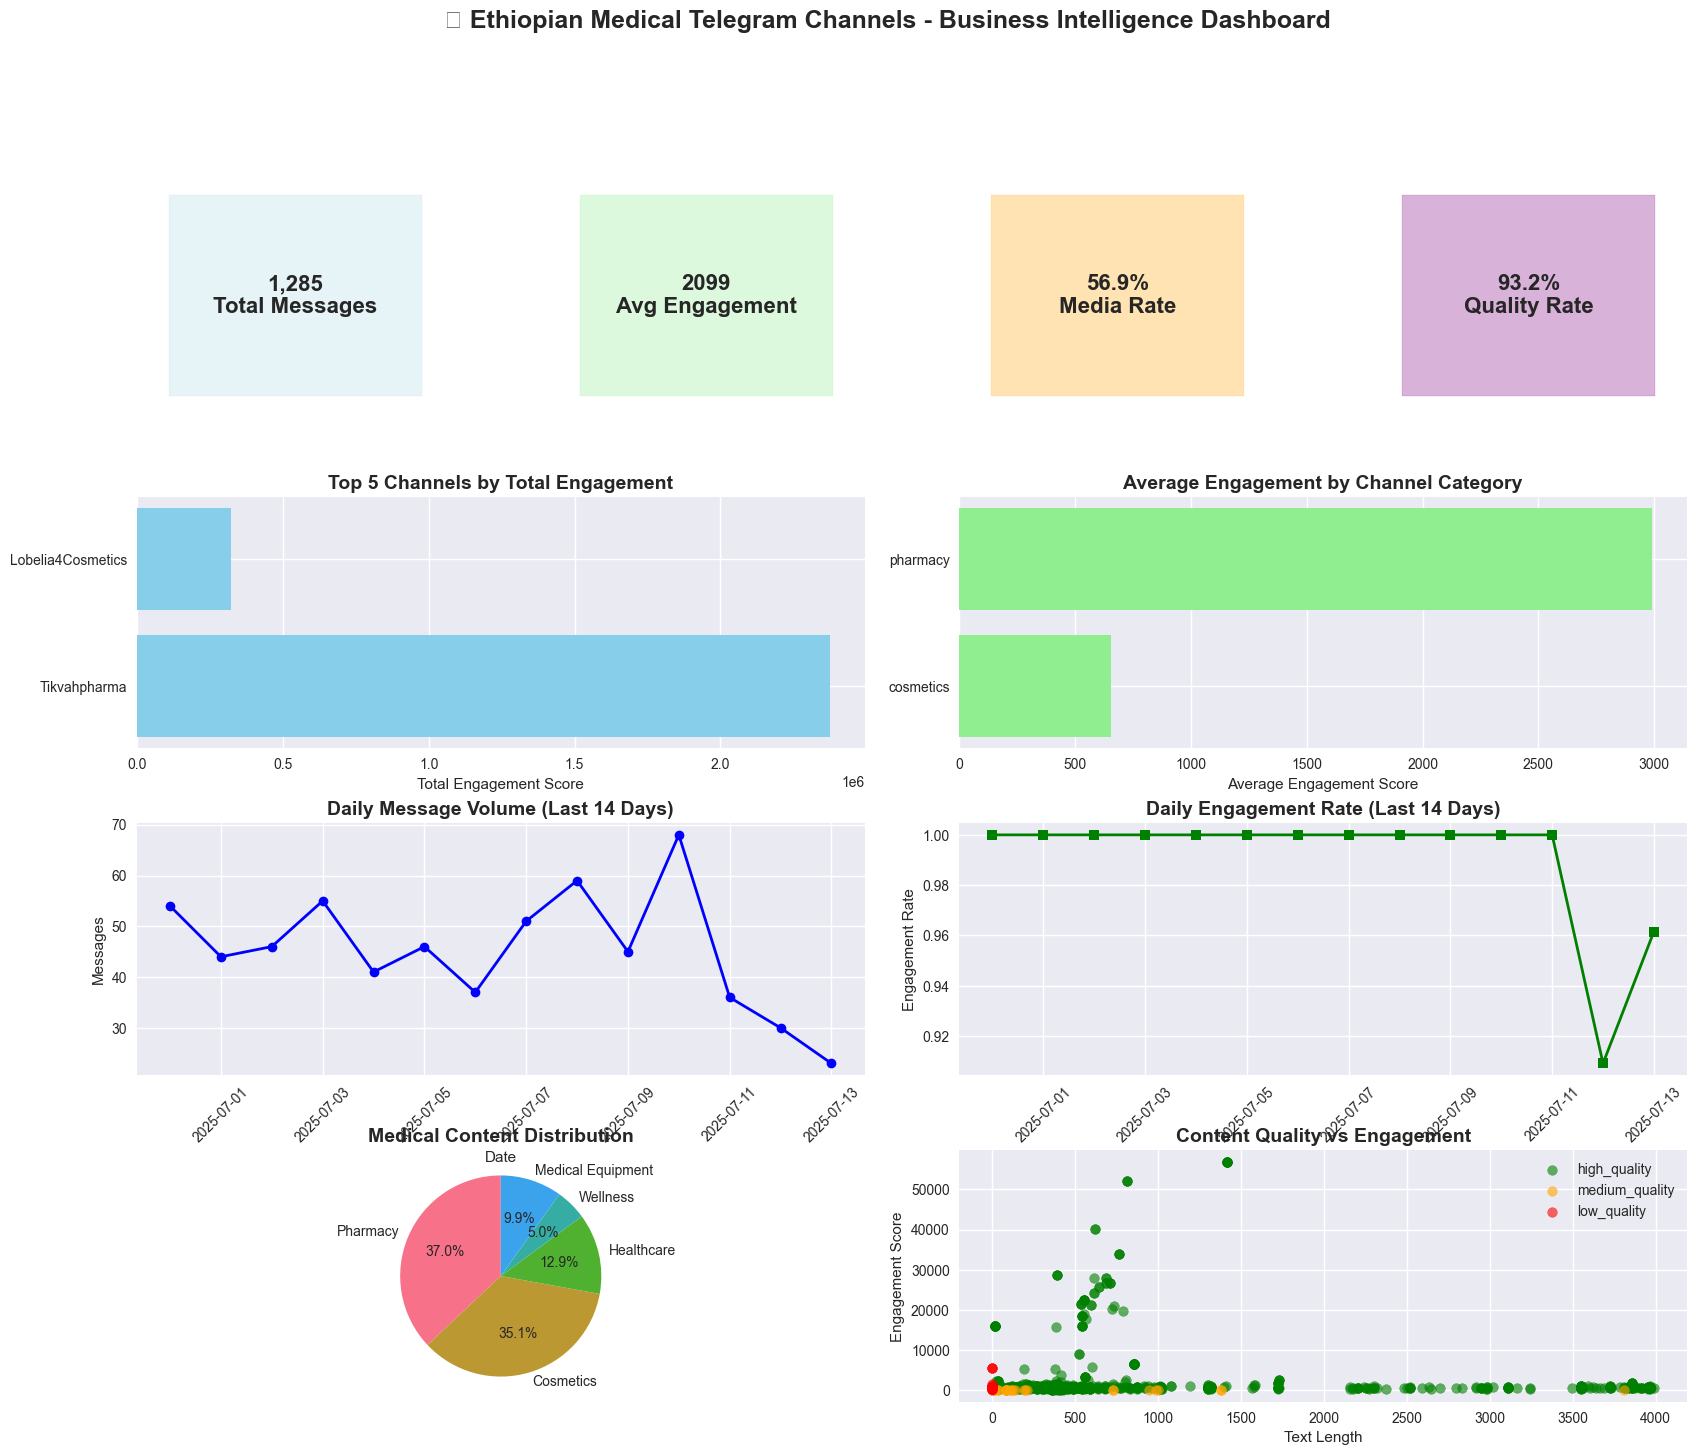


✅ Dashboard completed at: 2025-07-14 19:30:16
🎯 Ready for business decision making!


In [41]:
# Business Intelligence Dashboard - Key Metrics
print("📊 Business Intelligence Dashboard - Key Metrics")

# Key Performance Indicators
total_messages = len(df_warehouse)
total_channels = df_warehouse['channel'].nunique()
avg_engagement = df_warehouse['engagement_score'].mean()
total_engagement = df_warehouse['engagement_score'].sum()
media_rate = df_warehouse['has_media'].mean()
quality_rate = (df_warehouse['content_quality'] == 'high_quality').mean()

print("🎯 KEY PERFORMANCE INDICATORS")
print("=" * 50)
print(f"📊 Total Messages: {total_messages:,}")
print(f"📺 Active Channels: {total_channels}")
print(f"💬 Average Engagement: {avg_engagement:.1f}")
print(f"🔥 Total Engagement: {total_engagement:,}")
print(f"🖼️  Media Rate: {media_rate:.1%}")
print(f"⭐ High Quality Rate: {quality_rate:.1%}")

# Channel rankings
print(f"\n🏆 TOP PERFORMING CHANNELS")
print("=" * 50)
top_channels = df_warehouse.groupby('channel_display_name').agg({
    'engagement_score': 'sum',
    'message_key': 'count',
    'has_media': 'mean',
    'content_quality': lambda x: (x == 'high_quality').mean()
}).round(2)

top_channels.columns = ['Total_Engagement', 'Message_Count', 'Media_Rate', 'Quality_Rate']
top_channels = top_channels.sort_values('Total_Engagement', ascending=False).head(10)

for idx, (channel, data) in enumerate(top_channels.iterrows(), 1):
    print(f"{idx:2d}. {channel}")
    print(f"    Engagement: {data['Total_Engagement']:,.0f} | Messages: {data['Message_Count']:,} | Media: {data['Media_Rate']:.1%} | Quality: {data['Quality_Rate']:.1%}")

# Content performance summary
print(f"\n📋 CONTENT PERFORMANCE SUMMARY")
print("=" * 50)

content_summary = df_warehouse.groupby('channel_category').agg({
    'message_key': 'count',
    'engagement_score': ['sum', 'mean'],
    'has_media': 'mean',
    'content_quality': lambda x: (x == 'high_quality').mean(),
    'text_length': 'mean'
}).round(2)

content_summary.columns = ['Messages', 'Total_Eng', 'Avg_Eng', 'Media_Rate', 'Quality_Rate', 'Avg_Length']

for category, data in content_summary.iterrows():
    print(f"🏷️  {category.upper()}")
    print(f"    Messages: {data['Messages']:,} | Avg Engagement: {data['Avg_Eng']:.1f}")
    print(f"    Media Rate: {data['Media_Rate']:.1%} | Quality Rate: {data['Quality_Rate']:.1%}")

# Recent performance (last 7 days)
recent_data = df_warehouse[df_warehouse['message_date'] >= df_warehouse['message_date'].max() - pd.Timedelta(days=7)]

print(f"\n📅 RECENT PERFORMANCE (Last 7 Days)")
print("=" * 50)
print(f"📊 Messages: {len(recent_data):,}")
print(f"💬 Avg Daily Messages: {len(recent_data)/7:.0f}")
print(f"🔥 Avg Engagement: {recent_data['engagement_score'].mean():.1f}")
print(f"📈 Growth Rate: {((len(recent_data)/7) / (total_messages/len(daily_trends)) - 1)*100:+.1f}%")

# Create summary dashboard visualization
fig = plt.figure(figsize=(20, 16))

# Create a grid layout
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# KPI Cards (top row)
ax1 = fig.add_subplot(gs[0, 0])
ax1.text(0.5, 0.5, f'{total_messages:,}\nTotal Messages', ha='center', va='center', 
         fontsize=16, weight='bold', transform=ax1.transAxes)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')
ax1.add_patch(plt.Rectangle((0.1, 0.1), 0.8, 0.8, fill=True, color='lightblue', alpha=0.3))

ax2 = fig.add_subplot(gs[0, 1])
ax2.text(0.5, 0.5, f'{avg_engagement:.0f}\nAvg Engagement', ha='center', va='center', 
         fontsize=16, weight='bold', transform=ax2.transAxes)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')
ax2.add_patch(plt.Rectangle((0.1, 0.1), 0.8, 0.8, fill=True, color='lightgreen', alpha=0.3))

ax3 = fig.add_subplot(gs[0, 2])
ax3.text(0.5, 0.5, f'{media_rate:.1%}\nMedia Rate', ha='center', va='center', 
         fontsize=16, weight='bold', transform=ax3.transAxes)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.axis('off')
ax3.add_patch(plt.Rectangle((0.1, 0.1), 0.8, 0.8, fill=True, color='orange', alpha=0.3))

ax4 = fig.add_subplot(gs[0, 3])
ax4.text(0.5, 0.5, f'{quality_rate:.1%}\nQuality Rate', ha='center', va='center', 
         fontsize=16, weight='bold', transform=ax4.transAxes)
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.axis('off')
ax4.add_patch(plt.Rectangle((0.1, 0.1), 0.8, 0.8, fill=True, color='purple', alpha=0.3))

# Charts (remaining rows)
ax5 = fig.add_subplot(gs[1, :2])
top_channels_plot = top_channels.head(5)
ax5.barh(top_channels_plot.index, top_channels_plot['Total_Engagement'], color='skyblue')
ax5.set_title('Top 5 Channels by Total Engagement', fontsize=14, weight='bold')
ax5.set_xlabel('Total Engagement Score')

ax6 = fig.add_subplot(gs[1, 2:])
content_summary_plot = content_summary.sort_values('Avg_Eng', ascending=True)
ax6.barh(content_summary_plot.index, content_summary_plot['Avg_Eng'], color='lightgreen')
ax6.set_title('Average Engagement by Channel Category', fontsize=14, weight='bold')
ax6.set_xlabel('Average Engagement Score')

ax7 = fig.add_subplot(gs[2, :2])
daily_trends_recent = daily_trends.tail(14)  # Last 14 days
ax7.plot(daily_trends_recent['date_day'], daily_trends_recent['total_messages'], 
         marker='o', linewidth=2, color='blue')
ax7.set_title('Daily Message Volume (Last 14 Days)', fontsize=14, weight='bold')
ax7.set_xlabel('Date')
ax7.set_ylabel('Messages')
ax7.tick_params(axis='x', rotation=45)

ax8 = fig.add_subplot(gs[2, 2:])
ax8.plot(daily_trends_recent['date_day'], daily_trends_recent['engagement_rate'], 
         marker='s', linewidth=2, color='green')
ax8.set_title('Daily Engagement Rate (Last 14 Days)', fontsize=14, weight='bold')
ax8.set_xlabel('Date')
ax8.set_ylabel('Engagement Rate')
ax8.tick_params(axis='x', rotation=45)

# Content distribution pie chart
ax9 = fig.add_subplot(gs[3, :2])
content_dist = content_analysis['Message_Count']
ax9.pie(content_dist.values, labels=content_dist.index, autopct='%1.1f%%', startangle=90)
ax9.set_title('Medical Content Distribution', fontsize=14, weight='bold')

# Quality vs Engagement scatter
ax10 = fig.add_subplot(gs[3, 2:])
quality_colors = {'high_quality': 'green', 'medium_quality': 'orange', 'low_quality': 'red'}
for quality in quality_colors:
    subset = df_warehouse[df_warehouse['content_quality'] == quality]
    ax10.scatter(subset['text_length'], subset['engagement_score'], 
                c=quality_colors[quality], label=quality, alpha=0.6)
ax10.set_title('Content Quality vs Engagement', fontsize=14, weight='bold')
ax10.set_xlabel('Text Length')
ax10.set_ylabel('Engagement Score')
ax10.legend()

plt.suptitle('📊 Ethiopian Medical Telegram Channels - Business Intelligence Dashboard', 
             fontsize=18, weight='bold', y=0.98)

plt.show()

print(f"\n✅ Dashboard completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("🎯 Ready for business decision making!")
